In [1]:
!nvidia-smi
gpus= "0"

import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]= gpus;

import torch
gpu_count = torch.cuda.device_count()
print(torch.cuda.is_available())
print(gpu_count)

Wed Sep 16 07:27:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:05:00.0 Off |                  N/A |
| 33%   51C    P0    58W / 250W |      0MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:06:00.0 Off |                  N/A |
| 35%   51C    P0    59W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Matplotlib created a temporary config/cache directory at /home/kevin/.config/matplotlib because the default path (/tmp/matplotlib-tqy99zgo) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
path = 'data/datasets/signal/ASAN/segment_data/'
filelist = glob.glob(path+'*.csv')
print(len(filelist))

101133


In [4]:
x_normal = []
y_normal = []
x_abnormal = []
y_abnormal = []

threshold_normal = 1000
threshold_abnormal = 300

for idx in range(len(filelist)):
    if int(filelist[idx].split('/')[-1].split('_')[4].split('.')[0])<threshold_abnormal:
#         print('ab',int(filelist[idx].split('/')[-1].split('_')[4].split('.')[0]))
        x_abnormal.append(filelist[idx])
        y_abnormal.append('abnormal_'+str(filelist[idx].split('/')[-1].split('_')[4].split('.')[0]))
        
    elif int(filelist[idx].split('/')[-1].split('_')[4].split('.')[0])>threshold_normal:
#         print('no',int(filelist[idx].split('/')[-1].split('_')[4].split('.')[0]))
        x_normal.append(filelist[idx])
        y_normal.append('normal_'+str(filelist[idx].split('/')[-1].split('_')[4].split('.')[0]))

number_of_train = 40000
number_of_valid = 2000
number_of_test = 4000

x_train = x_normal[:number_of_train]
y_train = y_normal[:number_of_train]
x_valid = x_normal[number_of_train:number_of_train+number_of_valid]
y_valid = y_normal[number_of_train:number_of_train+number_of_valid]

x_test_normal = x_normal[number_of_train+number_of_valid:number_of_train+number_of_valid+number_of_test] 
y_test_normal = y_normal[number_of_train+number_of_valid:number_of_train+number_of_valid+number_of_test]
x_test_abnormal = x_abnormal[:number_of_test]
y_test_abnormal = y_abnormal[:number_of_test]

x_test = x_test_normal + x_test_abnormal
y_test = y_test_normal + y_test_abnormal

print('ab',len(x_abnormal),len(y_abnormal))
print('no',len(x_normal),len(y_normal))

print(len(x_train),len(y_train))
print(len(x_valid),len(y_valid))
print(len(x_test),len(y_test))

ab 20652 20652
no 46477 46477
40000 40000
2000 2000
8000 8000


Text(0, 0.5, 'Sample')

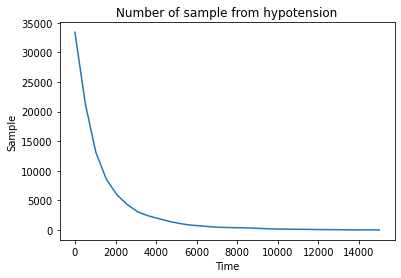

In [5]:
threshold = 500
x = np.linspace(0,15000,30)
y = np.zeros((30))

# histogram[idx][0]
for idx in range(len(filelist)):
    idx_hist = int(int(filelist[idx].split('/')[-1].split('_')[4].split('.')[0])/threshold)    
    y[idx_hist] += 1
    
plt.plot(x,y)
plt.title('Number of sample from hypotension')
plt.xlabel('Time')
plt.ylabel('Sample')

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import json
import math
import os
from collections import defaultdict

import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torch.distributions as dist

from torchvision import datasets, transforms
from torchvision.utils import save_image

from trixi.logger.experiment.pytorchexperimentlogger import PytorchExperimentLogger
from trixi.logger import PytorchPlotFileLogger
from trixi.util import Config
from trixi.util.pytorchutils import set_seed

# class VAE(nn.Module):
#     def __init__(self, z=20, input_size=784):
#         super(VAE, self).__init__()

#         self.fc1 = nn.Linear(input_size, 400)
#         self.fc21 = nn.Linear(400, z)
#         self.fc22 = nn.Linear(400, z)
#         self.fc3 = nn.Linear(z, 400)
#         self.fc4 = nn.Linear(400, input_size)

#     def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
# #         return torch.sigmoid(self.fc4(h3))
#         return self.fc4(h3)

#     def forward(self, x):
#         mu, logstd = self.encode(x)
#         z = self.reparameterize(mu, logstd)
#         return self.decode(z), mu, logstd


# def loss_function(recon_x, x, mu, logstd, rec_log_std=0):
#     rec_std = math.exp(rec_log_std)
#     rec_var = rec_std ** 2

#     x_dist = dist.Normal(recon_x, rec_std)
#     log_p_x_z = torch.sum(x_dist.log_prob(x), dim=1)

#     z_prior = dist.Normal(0, 1.)
#     z_post = dist.Normal(mu, torch.exp(logstd))
#     kl_div = torch.sum(dist.kl_divergence(z_post, z_prior), dim=1)

#     return torch.mean(kl_div - log_p_x_z), kl_div, -log_p_x_z

# def loss_function(recon_x, x, mu, logstd, rec_log_std=0):
#     rec_std = math.exp(rec_log_std)
#     rec_var = rec_std ** 2

# #     x_dist = dist.Normal(recon_x, rec_std)
# #     log_p_x_z = torch.sum(x_dist.log_prob(x), dim=1)

# #     z_prior = dist.Normal(0, 1.)
# #     z_post = dist.Normal(mu, torch.exp(logstd))
# #     kl_div = torch.sum(dist.kl_divergence(z_post, z_prior), dim=1)
    
#     recons_loss =F.mse_loss(recon_x, x)
#     kld_loss = torch.mean(-0.5 * torch.sum(1 + logstd - mu ** 2 - logstd.exp(), dim = 1), dim = 0)
    
#     loss = recons_loss + kld_loss

#     return loss, -kld_loss, recons_loss
# #     return torch.mean(kl_div - log_p_x_z), kl_div, -log_p_x_z



# def loss_function(self,
#                   *args,
#                   **kwargs) -> dict:
#         """
#         Computes the VAE loss function.
#         KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
#         :param args:
#         :param kwargs:
#         :return:
#         """
#         recons = args[0]
#         input = args[1]
#         mu = args[2]
#         log_var = args[3]

#         kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
#         recons_loss =F.mse_loss(recons, input)


#         kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

#         loss = recons_loss + kld_weight * kld_loss
#         return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}


def train(epoch, model, optimizer, train_loader, device, scaling, vlog, elog, log_var_std):
    model.train()

    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.to(device)
        data_flat = data#.flatten(start_dim=1).repeat(1, scaling)
        print(data_flat.shape)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_flat)
        loss, kl, rec = loss_function(recon_batch, data_flat, mu, logvar, log_var_std)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() / len(data)))
            # vlog.show_value(torch.mean(kl).item(), name="Kl-loss", tag="Losses")
            # vlog.show_value(torch.mean(rec).item(), name="Rec-loss", tag="Losses")
            # vlog.show_value(loss.item(), name="Total-loss", tag="Losses")

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))


def test(model, test_loader, test_loader_abnorm, device, scaling, vlog, elog, image_size, batch_size, log_var_std):
    model.eval()
    test_loss = []
    kl_loss = []
    rec_loss = []
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
#             data_flat = data.flatten(start_dim=1).repeat(1, scaling)
            data_flat = data
            recon_batch, mu, logvar = model(data_flat)
            loss, kl, rec = loss_function(recon_batch, data_flat, mu, logvar, log_var_std)
            test_loss += (kl + rec).tolist()
            kl_loss += kl.tolist()
            rec_loss += rec.tolist()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:, :image_size].view(batch_size, 1, 28, 28)[:n]])
                # vlog.show_image_grid(comparison.cpu(),   name='reconstruction')
    test_loss_ab = []
    kl_loss_ab = []
    rec_loss_ab = []
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader_abnorm):
            data = data.to(device)
#             data_flat = data.flatten(start_dim=1).repeat(1, scaling)
            data_flat = data
            recon_batch, mu, logvar = model(data_flat)
            loss, kl, rec = loss_function(recon_batch, data_flat, mu, logvar, log_var_std)
            test_loss_ab += (kl + rec).tolist()
            kl_loss_ab += kl.tolist()
            rec_loss_ab += rec.tolist()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch[:, :image_size].view(batch_size, 1, 28, 28)[:n]])
                # vlog.show_image_grid(comparison.cpu(),                                     name='reconstruction2')

    print('====> Test set loss: {:.4f}'.format(np.mean(test_loss)))

    kl_roc, kl_pr = elog.get_classification_metrics(kl_loss + kl_loss_ab,
                                                    [0] * len(kl_loss) + [1] * len(kl_loss_ab),
                                                    )[0]
    rec_roc, rec_pr = elog.get_classification_metrics(rec_loss + rec_loss_ab,
                                                      [0] * len(rec_loss) + [1] * len(rec_loss_ab),
                                                      )[0]
    loss_roc, loss_pr = elog.get_classification_metrics(test_loss + test_loss_ab,
                                                        [0] * len(test_loss) + [1] * len(test_loss_ab),
                                                        )[0]

    # vlog.show_value(np.mean(kl_roc), name="KL-loss", tag="ROC")
    # vlog.show_value(np.mean(rec_roc), name="Rec-loss", tag="ROC")
    # vlog.show_value(np.mean(loss_roc), name="Total-loss", tag="ROC")
    # elog.show_value(np.mean(kl_roc), name="KL-loss", tag="ROC")
    # elog.show_value(np.mean(rec_roc), name="Rec-loss", tag="ROC")
    # elog.show_value(np.mean(loss_roc), name="Total-loss", tag="ROC")

    # vlog.show_value(np.mean(kl_pr), name="KL-loss", tag="PR")
    # vlog.show_value(np.mean(rec_pr), name="Rec-loss", tag="PR")
    # vlog.show_value(np.mean(loss_pr), name="Total-loss", tag="PR")

    return kl_roc, rec_roc, loss_roc, kl_pr, rec_pr, loss_pr

In [7]:
# !pip install trixi

In [8]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

def preprocess(data):
    data = data/200.
    return data

def postprocess(data):
    data = data*200.
    return data

class ABPdataset():
    def __init__(self,x_list, y_list, augmentation=None):
        self.x_list = x_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.x_list)
        
    def __getitem__(self,idx):
        sample = pd.read_csv(self.x_list[idx])
        array = sample.to_numpy().squeeze().astype(np.float32)
        
        length = 784
        
        randnumber = np.random.randint(0,len(array)-length,1)
        randnumber = randnumber[0]
        
        temp = np.zeros(length)
        temp = array[randnumber:randnumber+length]
        array = temp.astype(np.float32)
        
        array = preprocess(array)
        array = np.expand_dims(array,0)        
        
        label = self.y_list[idx]
        
        return array, label
    
train_dataset = ABPdataset(x_train,y_train)
valid_dataset = ABPdataset(x_valid,y_valid)
test_dataset = ABPdataset(x_test,y_test)
test_dataset_normal = ABPdataset(x_test_normal,y_test_normal)
test_dataset_abnormal = ABPdataset(x_test_abnormal,y_test_abnormal)

In [9]:
# plt.hist(wave.flatten())

In [10]:
batch_size = 32
odd_class = 0
z = 32
seed = 123
log_var_std = 0.
n_epochs=100
input_size = 2048

# model_run(scaling, batch_size, odd_class, z, seed, log_var_std)

In [11]:
# class AE(nn.Module):
#     def __init__(self, **kwargs):
#         super().__init__()
#         self.encoder_hidden_layer = nn.Linear(
#             in_features=kwargs["input_shape"], out_features=128
#         )
#         self.encoder_output_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_hidden_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_output_layer = nn.Linear(
#             in_features=128, out_features=kwargs["input_shape"]
#         )

#     def forward(self, features):
#         activation = self.encoder_hidden_layer(features)
#         activation = torch.relu(activation)
#         code = self.encoder_output_layer(activation)
#         code = torch.relu(code)
#         activation = self.decoder_hidden_layer(code)
#         activation = torch.relu(activation)
#         activation = self.decoder_output_layer(activation)
#         reconstructed = torch.sigmoid(activation)
#         return reconstructed
    
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
       
#         #Encoder
#         self.conv1 = nn.Conv1d(3, 16, 3, padding=1)  
#         self.conv2 = nn.Conv1d(16, 4, 3, padding=1)
#         self.pool = nn.MaxPool1d(2, 2)
       
#         #Decoder
#         self.t_conv1 = nn.ConvTranspose1d(4, 16, 2, stride=2)
#         self.t_conv2 = nn.ConvTranspose1d(16, 3, 2, stride=2)


#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = F.relu(self.t_conv1(x))
#         x = F.sigmoid(self.t_conv2(x))
              
#         return x

class autoencoder(nn.Module):
    def __init__(self,length = 784):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size= 3, stride= 2, padding  = 1),  # b, 16, 10, 10
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Conv1d(16, 8, kernel_size= 3, stride= 2, padding  = 1),  # b, 16, 10, 10
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
#             nn.MaxPool1d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ConvTranspose1d(8, 16, kernel_size= 3, stride= 2, padding  = 1),  # b, 16, 5, 5
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size= 3, stride= 2, padding  = 1),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),            
            nn.Conv1d(8, 1, kernel_size= 2, stride= 1, padding= 2),
            nn.Sigmoid()
#             nn.Tanh()
        )
        
    def forward(self, x):
#         print('i',x.shape)
        x = self.encoder(x)
#         print('e',x.shape)
        x = self.decoder(x)
#         print('d',x.shape)
        return x

# class autoencoder(nn.Module):
#     def __init__(self,length = 784):
#         super(autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv1d(1, 32, kernel_size= 3, stride= 2, padding  = 1),  # b, 16, 10, 10
#             nn.BatchNorm1d(32),
#             nn.LeakyReLU(),
#             nn.Conv1d(32, 16, kernel_size= 3, stride= 2, padding  = 1),  # b, 16, 10, 10
#             nn.BatchNorm1d(16),
#             nn.LeakyReLU(),
#             nn.Conv1d(16, 8, kernel_size= 3, stride= 2, padding  = 1),  # b, 16, 10, 10
#             nn.BatchNorm1d(8),
#             nn.LeakyReLU(),
# #             nn.MaxPool1d(2, stride=1)  # b, 8, 2, 2
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(8, 16, kernel_size= 3, stride= 2, padding  = 1),  # b, 16, 5, 5
#             nn.BatchNorm1d(16),
#             nn.LeakyReLU(),
#             nn.ConvTranspose1d(16, 32, kernel_size= 3, stride= 2, padding  = 1),  # b, 16, 5, 5
#             nn.BatchNorm1d(32),
#             nn.LeakyReLU(),
#             nn.ConvTranspose1d(32, 1, kernel_size= 3, stride= 2, padding  = 1),
#             nn.BatchNorm1d(1),
#             nn.LeakyReLU(),            
# #             nn.Conv1d(8, 1, kernel_size= 2, stride= 1, padding= 2),
#             nn.Tanh()
#         )
        
#     def forward(self, x):
#         print('i',x.shape)
#         x = self.encoder(x)
#         print('e',x.shape)
#         x = self.decoder(x)
#         print('d',x.shape)
#         return x
    

    
# class autoencoder(nn.Module):
#     def __init__(self,length = 784):
#         super(autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv1d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
#             nn.BatchNorm1d(16),
# #             nn.ReLU(True),
#             nn.LeakyReLU(),
#             nn.MaxPool1d(2, stride=2),  # b, 16, 5, 5
#             nn.Conv1d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
#             nn.BatchNorm1d(8),
# #             nn.ReLU(True),
#             nn.LeakyReLU(),
#             nn.MaxPool1d(2, stride=1)  # b, 8, 2, 2
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(8, 16, 3, stride=2, padding=1),  # b, 16, 5, 5
# #             nn.ReLU(True),
#             nn.LeakyReLU(),
#             nn.ConvTranspose1d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
# #             nn.ReLU(True),
#             nn.LeakyReLU(),
#             nn.ConvTranspose1d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
# #             nn.Sigmoid()
#             nn.Tanh()
#         )
        
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# model = AE(input_shape= 2000)

# # device = torch.device("cuda:0")
# # model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # mean-squared error loss
criterion = nn.MSELoss()

In [12]:
model = autoencoder()
model

autoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv1d(16, 8, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(8, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose1d(16, 8, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(8, 1, kernel_size=(2,), stride=(1,), padding=(2,))
    (7): Sigmoid()
  )
)

In [13]:
# class VAE(nn.Module):
#     def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
#         super(VAE, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv1d(image_channels, 32, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv1d(32, 64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv1d(64, 128, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv1d(128, 256, kernel_size=4, stride=2),
#             nn.ReLU(),
#             Flatten()
#         )
        
#         self.fc1 = nn.Linear(h_dim, z_dim)
#         self.fc2 = nn.Linear(h_dim, z_dim)
#         self.fc3 = nn.Linear(z_dim, h_dim)
        
#         self.decoder = nn.Sequential(
#             UnFlatten(),
#             nn.ConvTranspose1d(h_dim, 128, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose1d(32, image_channels, kernel_size=4, stride=2),
#             nn.Sigmoid(),
#         )
        
#     def reparameterize(self, mu, logvar):
#         std = logvar.mul(0.5).exp_()
#         # return torch.normal(mu, std)
#         esp = torch.randn(*mu.size())
#         z = mu + std * esp
#         return z
    
#     def bottleneck(self, h):
#         mu, logvar = self.fc1(h), self.fc2(h)
#         z = self.reparameterize(mu, logvar)
#         return z, mu, logvar

#     def encode(self, x):
#         h = self.encoder(x)
#         print(h.shape)
#         z, mu, logvar = self.bottleneck(h)
#         return z, mu, logvar

#     def decode(self, z):
#         z = self.fc3(z)
#         z = self.decoder(z)
#         return z

#     def forward(self, x):
#         z, mu, logvar = self.encode(x)
#         z = self.decode(z)
#         return z, mu, logvar
    
# class Flatten(nn.Module):
#     def forward(self, input):
#         return input.view(input.size(0), -1)
    
# class UnFlatten(nn.Module):
#     def forward(self, input, size=1024):
#         return input.view(input.size(0), 1024, 2016)
    
# model = VAE(h_dim=32256)
# # model = VAE(h_dim=1024)

In [24]:
set_seed(seed)

config = Config(batch_size=batch_size,
                odd_class=odd_class,
                z=z,
                seed=seed,
                log_var_std=log_var_std,
                n_epochs=n_epochs
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader_abnormal = torch.utils.data.DataLoader(test_dataset_abnormal, batch_size=batch_size, shuffle=True)
test_loader_normal = torch.utils.data.DataLoader(test_dataset_normal, batch_size=batch_size, shuffle=True)

# input_size = 784
# model = VAE(z=z, input_size=input_size)#.to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# vlog = PytorchPlotFileLogger(exp_name="vae-fmnist",img_dir='img_dir',plot_dir='plot_dir')
# elog = PytorchExperimentLogger(base_dir="data/logs/mnist_exp_fin", exp_name="fashion-mnist_vae")

In [15]:
# model_w

In [16]:
model_w = torch.load('signal_anomaly_500.pt')
model.load_state_dict(model_w['model_state_dict'])

<All keys matched successfully>

In [37]:
for epoch in range(1, n_epochs + 1):
    model.train()

    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data_flat = data#.to(device)
        optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data_flat)
#         loss, kl, rec = loss_function(recon_batch, data_flat, mu, logvar, log_var_std)
        
        pred = model(data)
        loss = criterion(pred,data)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, 
                        batch_idx * len(data), 
                        len(train_loader.dataset),
                        100. * batch_idx / len(train_loader),
                        loss.item() / len(data)))

    print('====> Epoch: {} Average train loss: {:.7f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    model.eval()
    valid_loss = 0
    for batch_idx, (data, _) in enumerate(valid_loader):
        data_flat = data#.to(device)
#         recon_batch, mu, logvar = model(data_flat)
#         loss, kl, rec = loss_function(recon_batch, data_flat, mu, logvar, log_var_std)
        
        pred = model(data)
        loss = criterion(pred,data)
        
        valid_loss += loss.item()

    print('====> Epoch: {} Average valid loss: {:.7f}'.format(epoch, valid_loss / len(valid_loader.dataset)))

Train Epoch: 1 [0/40000 (0%)]	Loss: 0.000005


KeyboardInterrupt: 

In [43]:
# torch.save(model,'signal_anomaly.pt')

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'signal_anomaly_'+str(threshold)+'.pt')

torch.Size([32, 1, 784]) torch.Size([32, 1, 784])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


tensor(3.9160) tensor(11.0273) tensor(0.7681) tensor(3.0725)


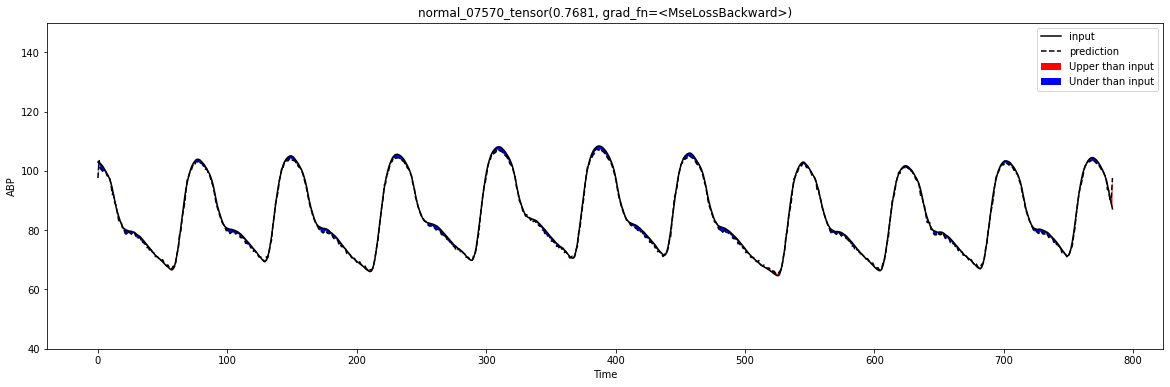

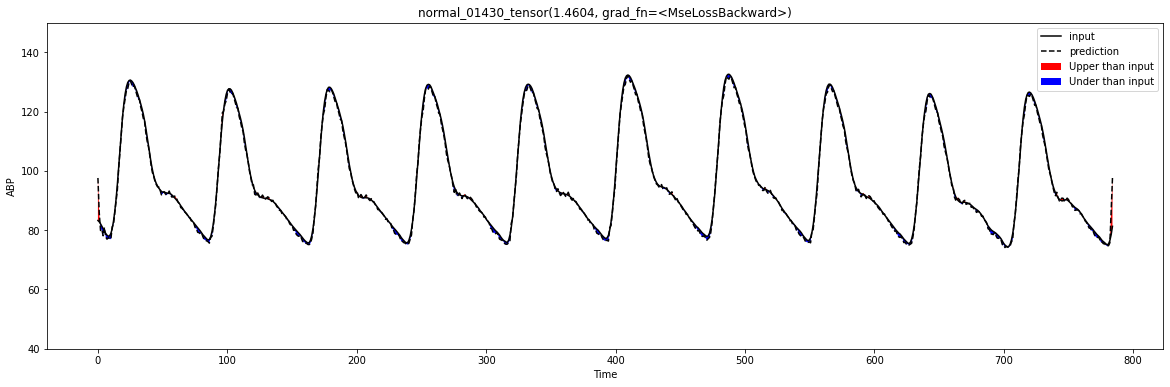

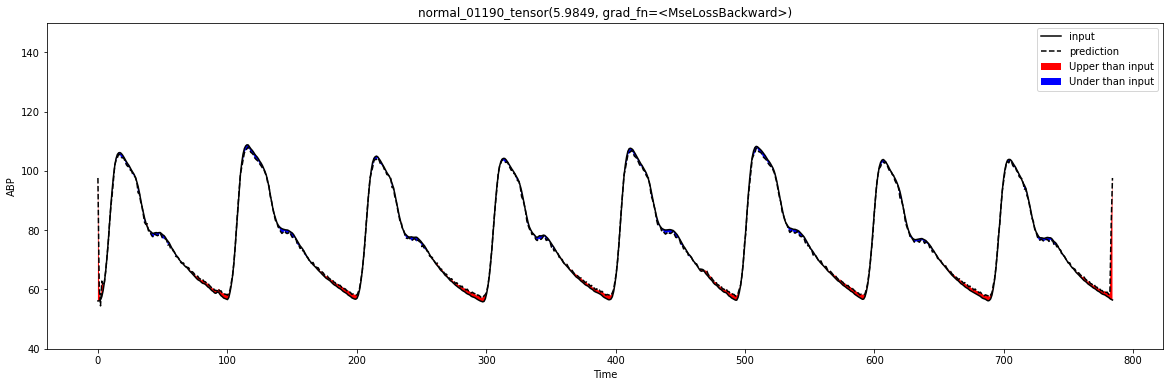

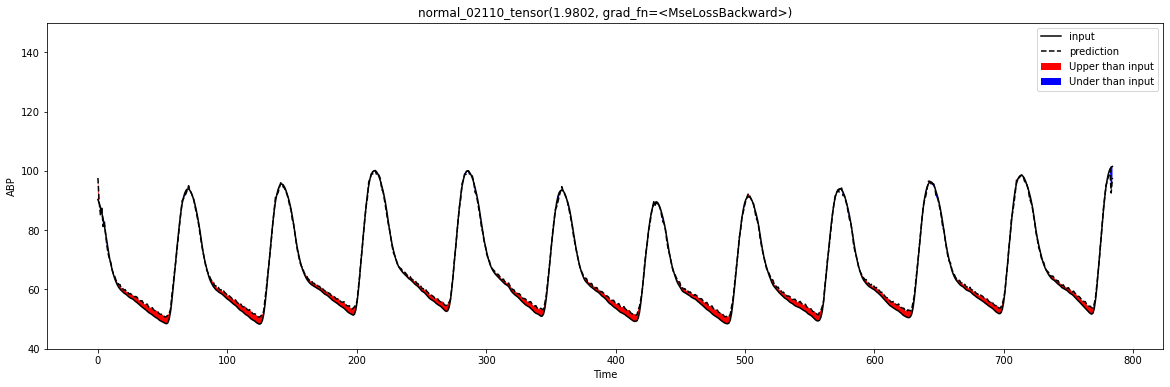

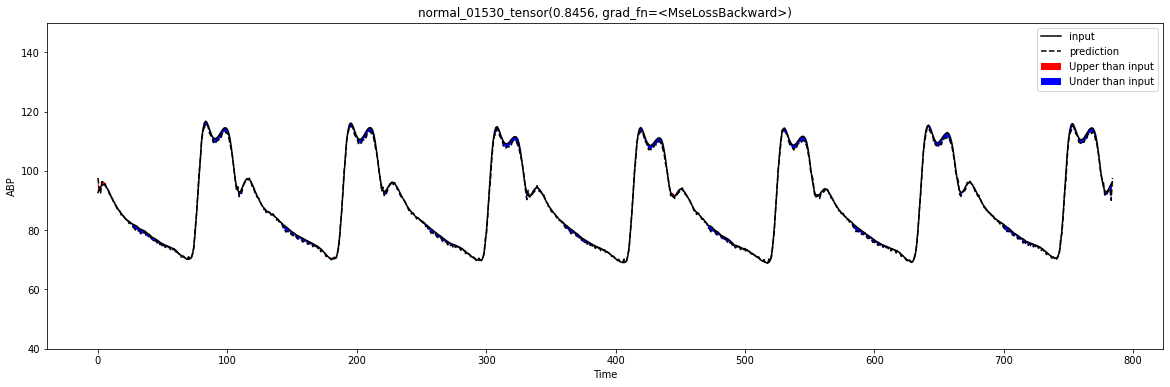

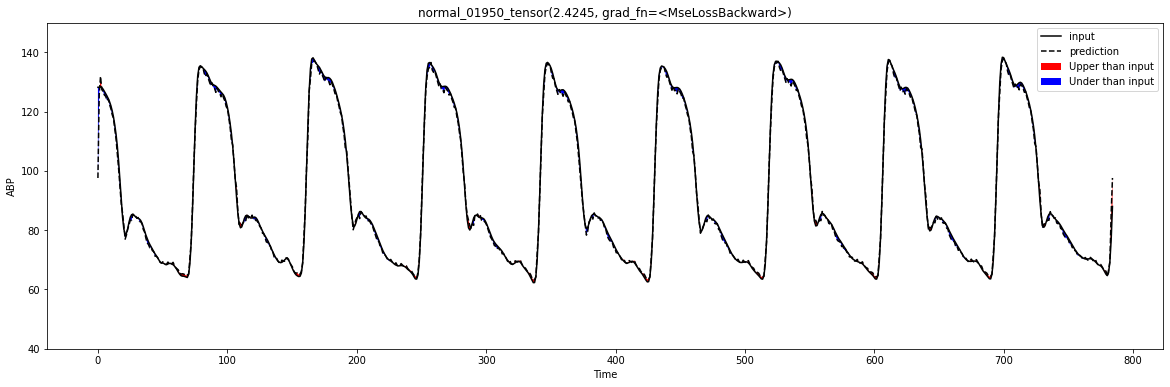

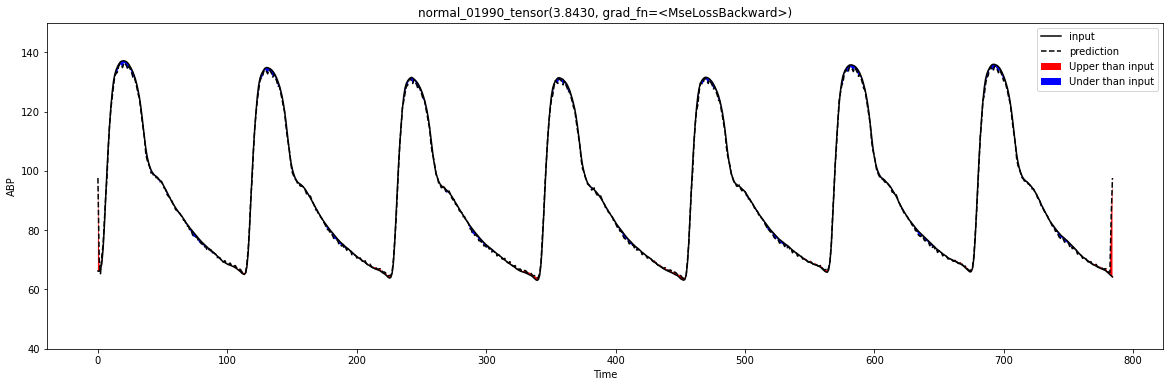

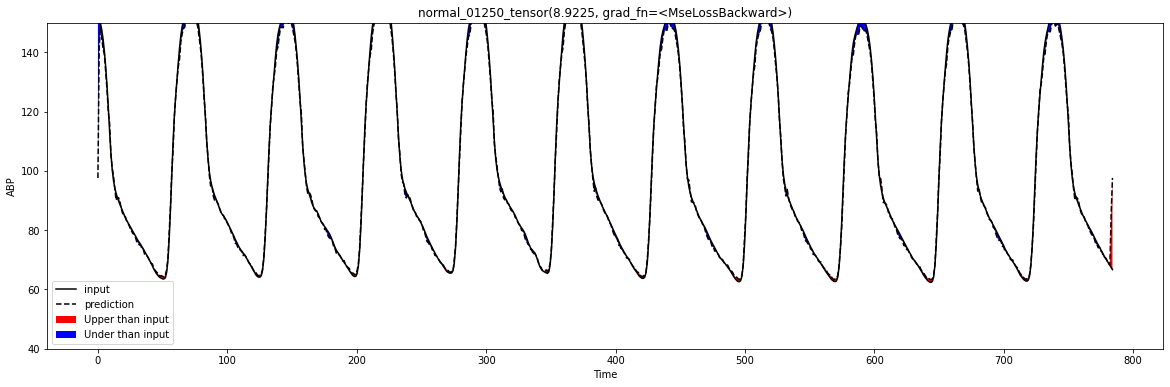

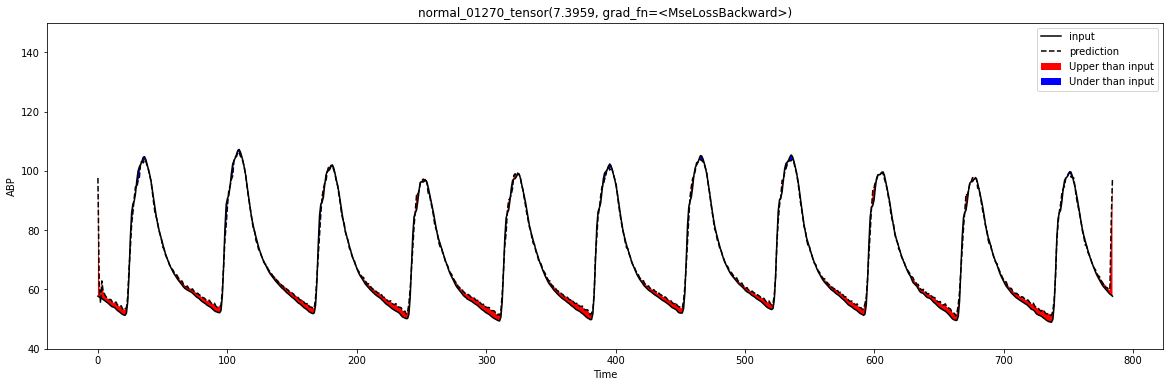

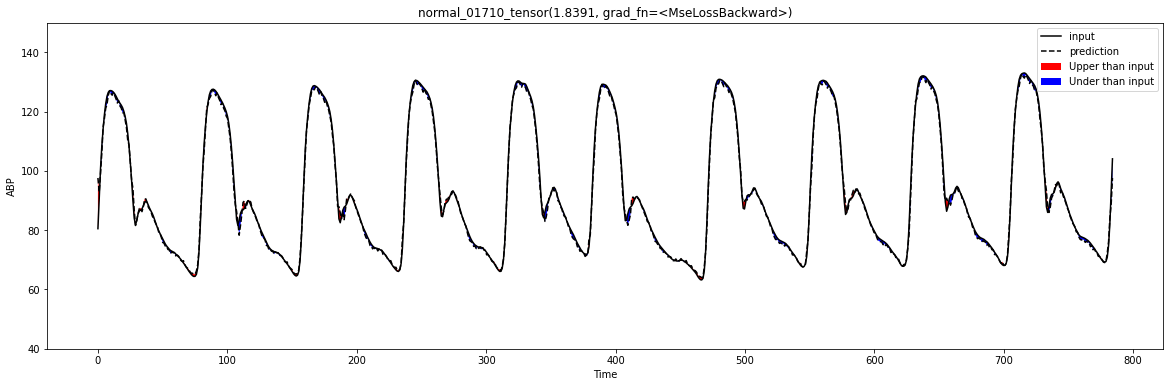

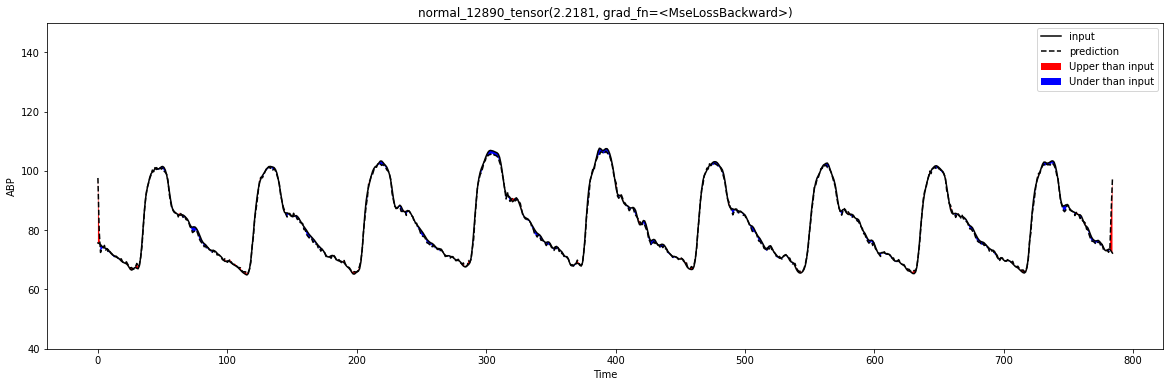

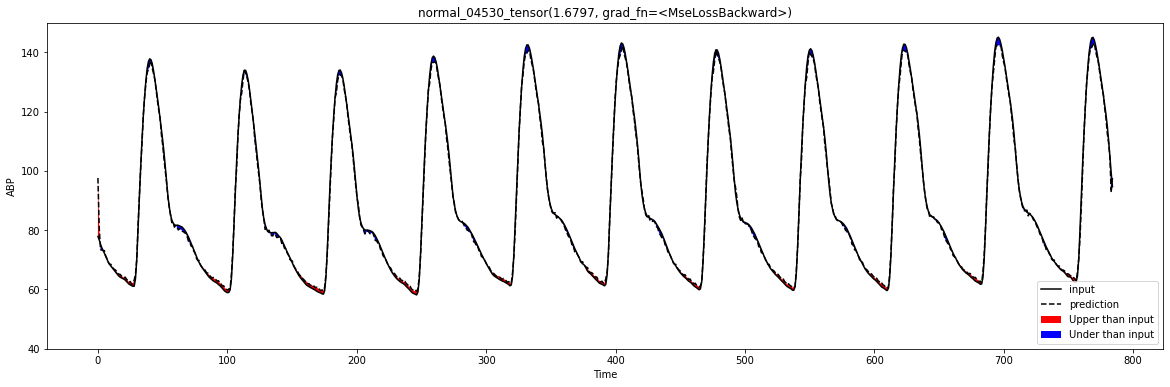

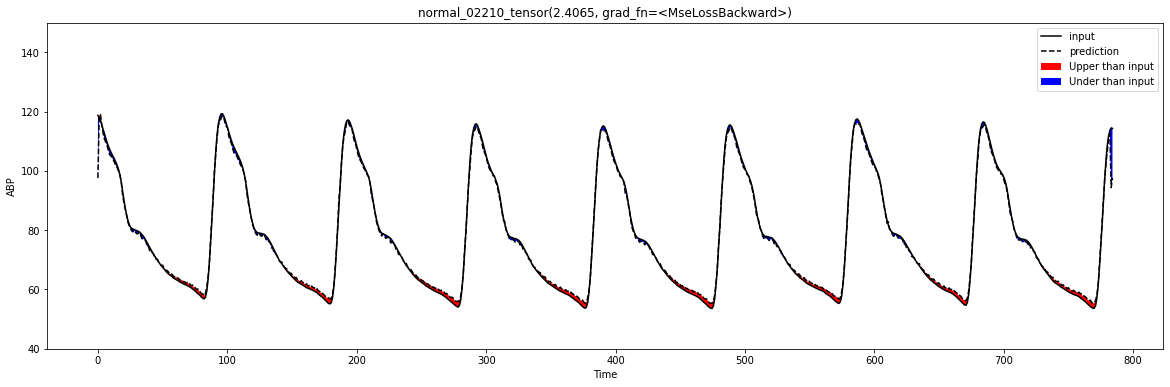

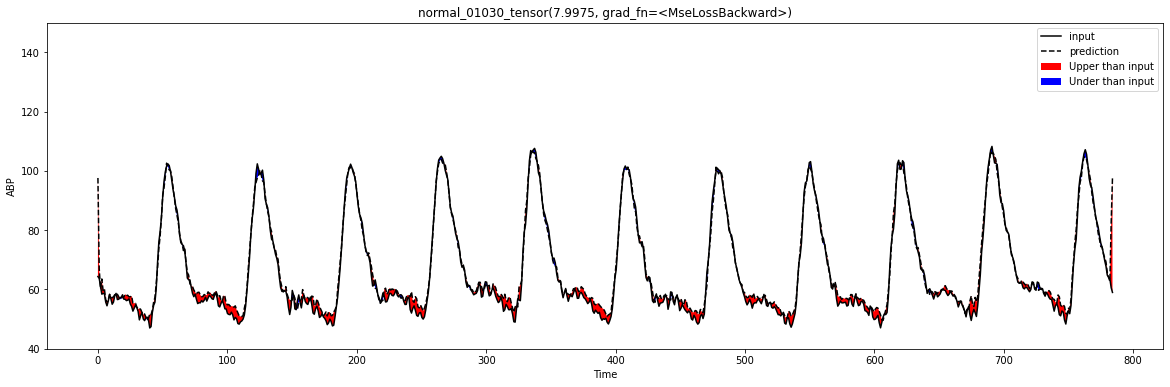

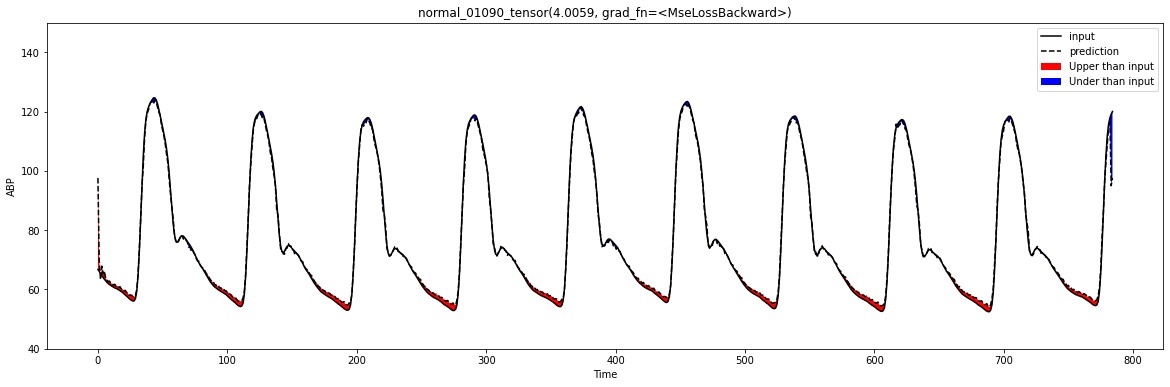

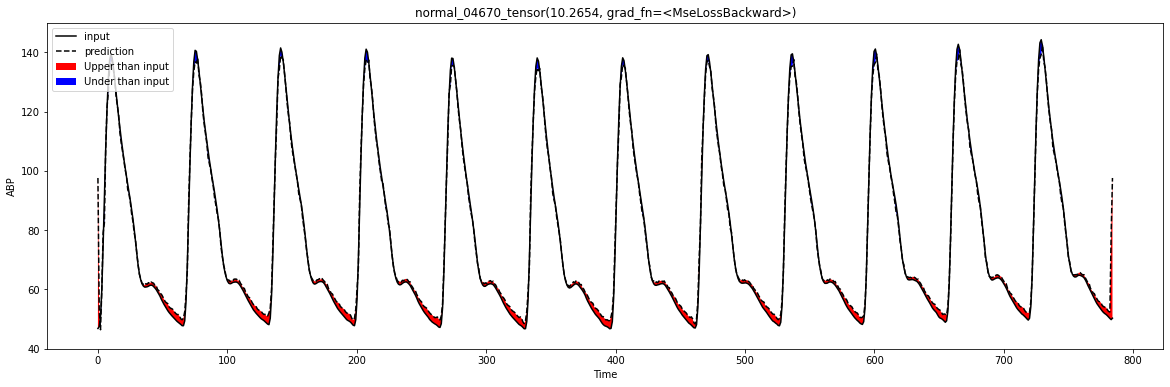

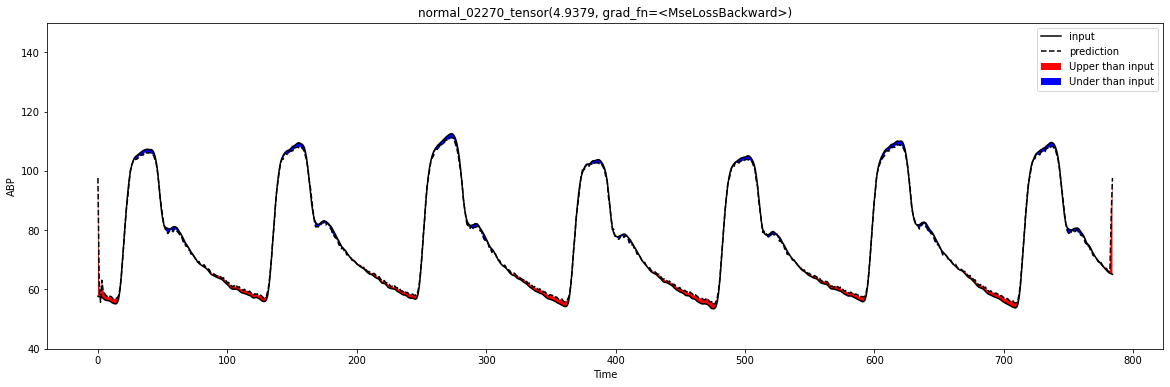

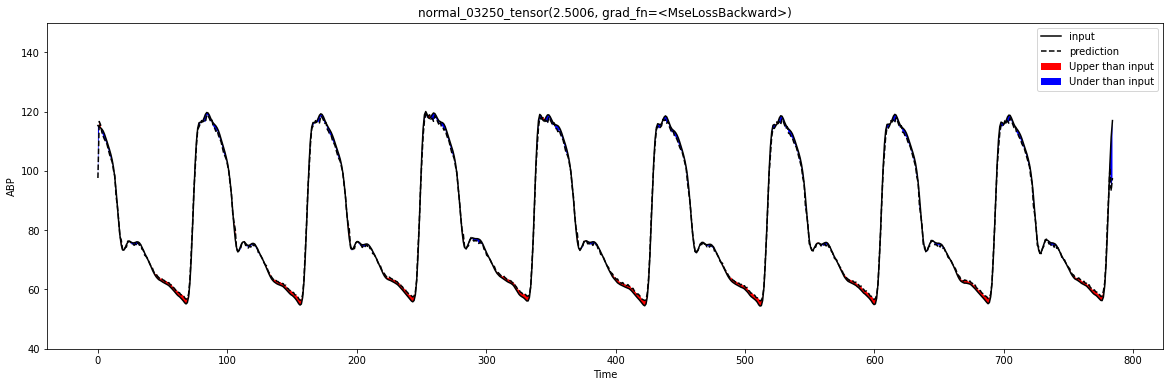

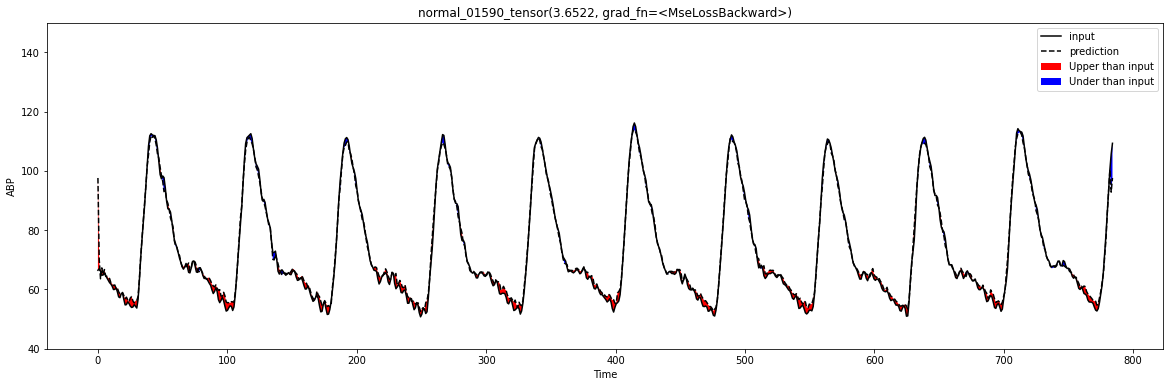

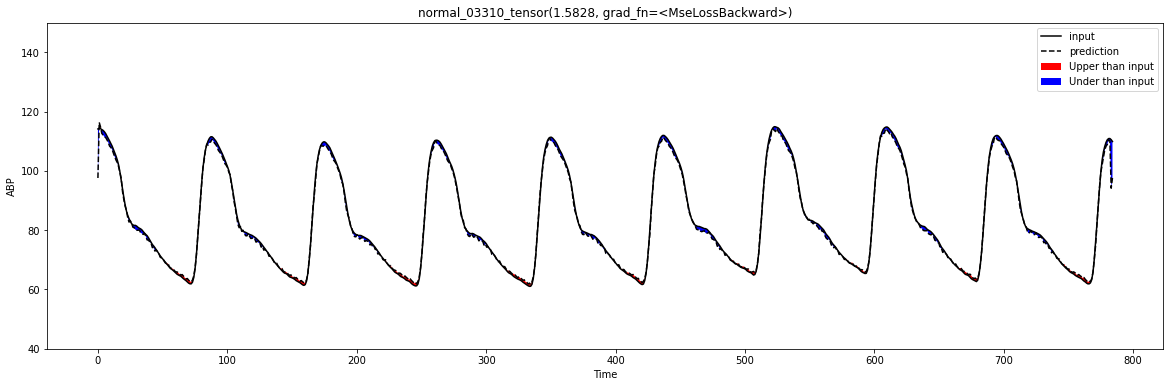

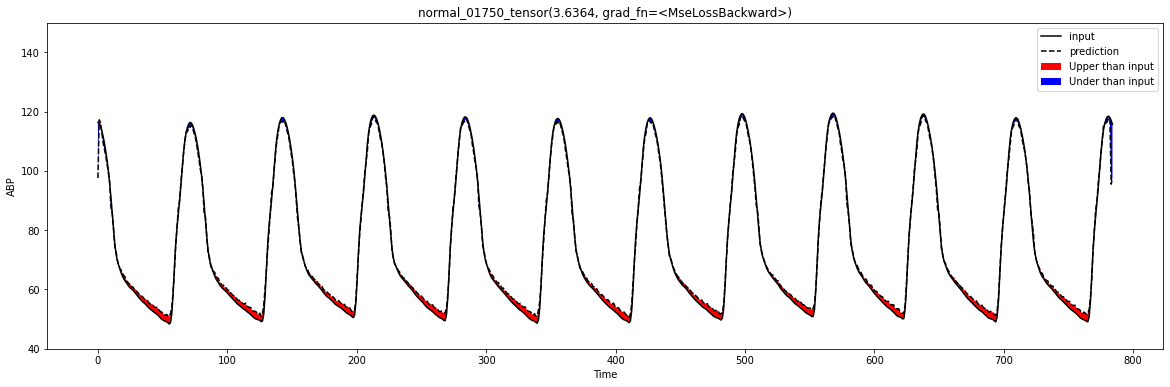

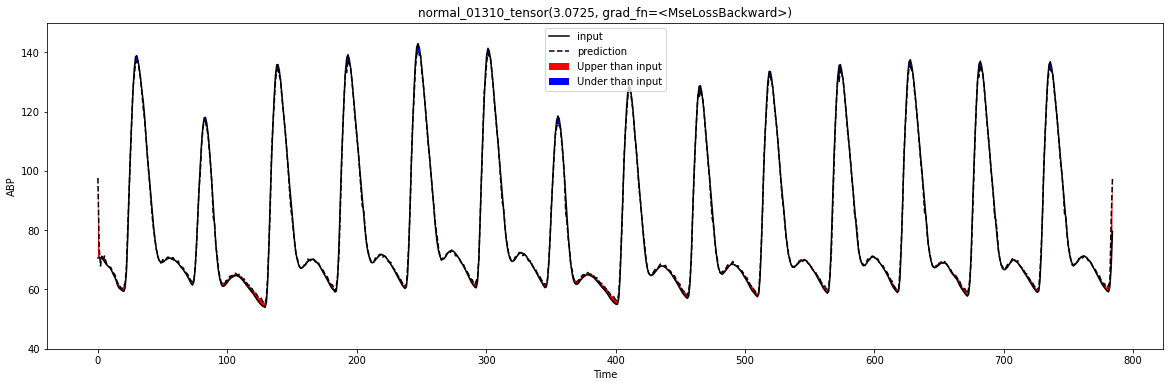

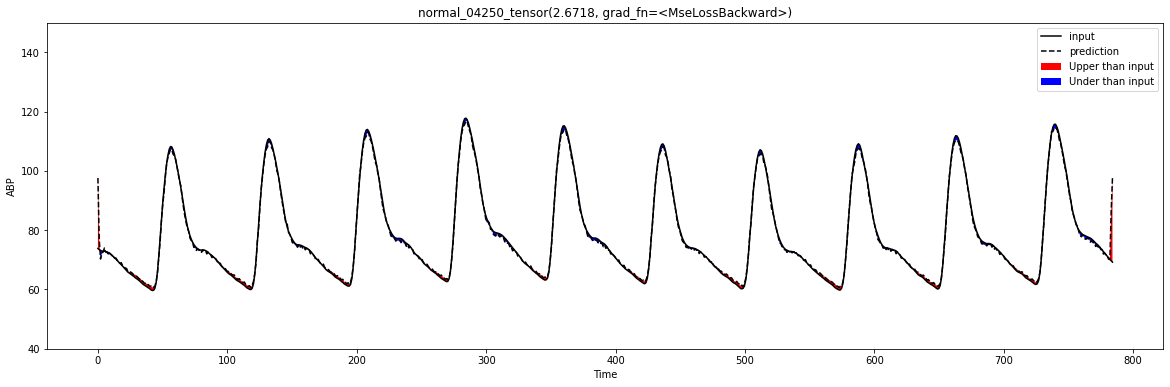

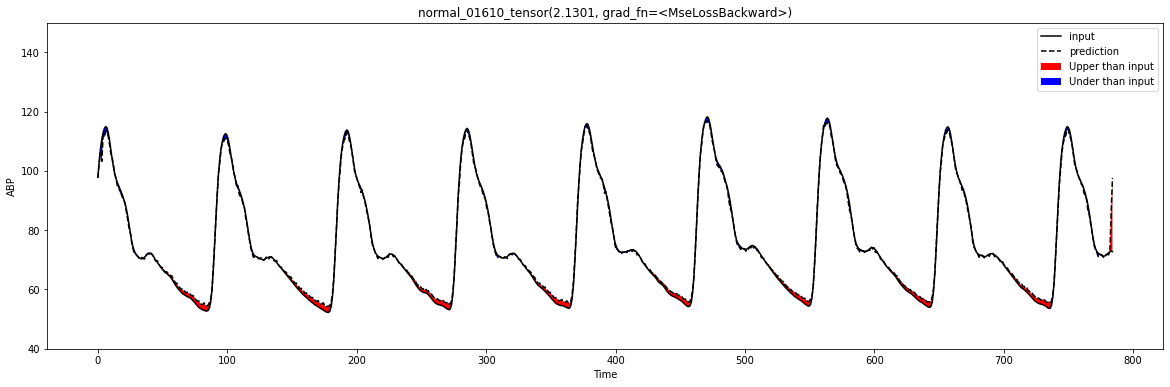

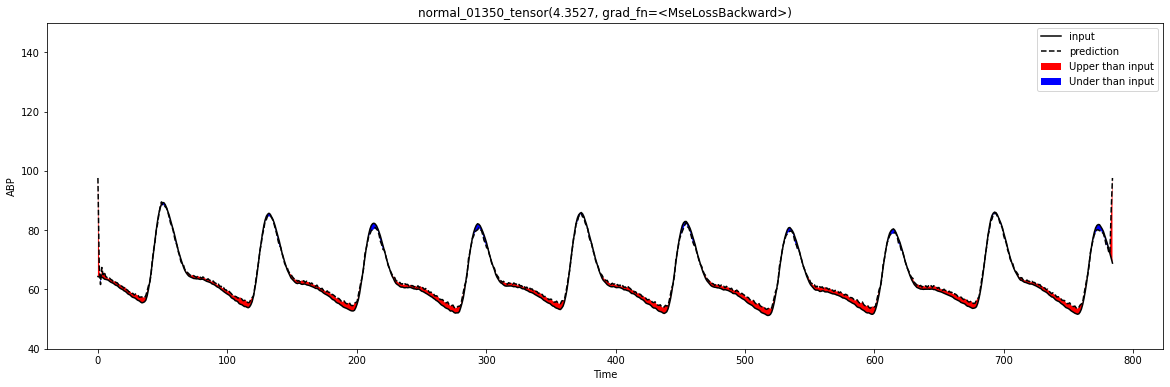

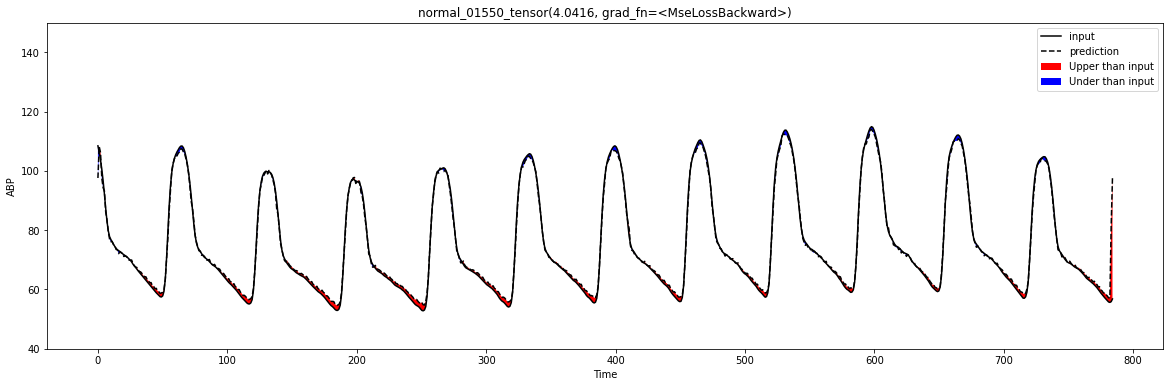

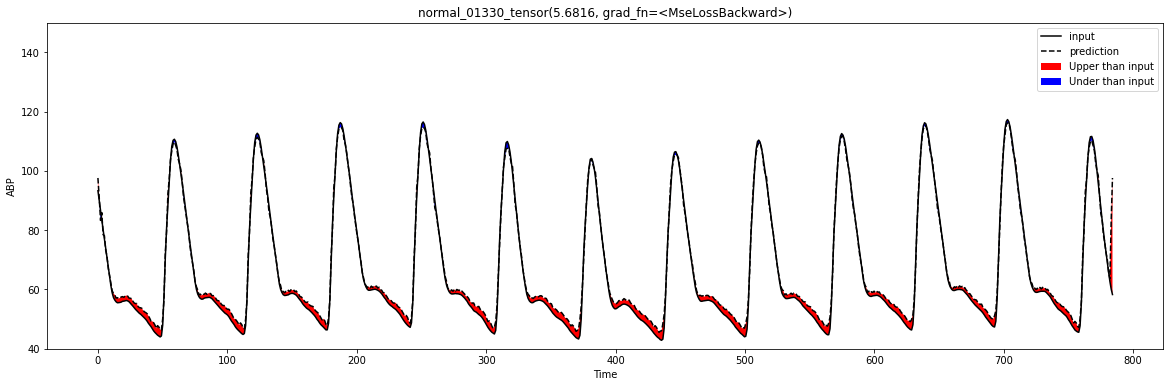

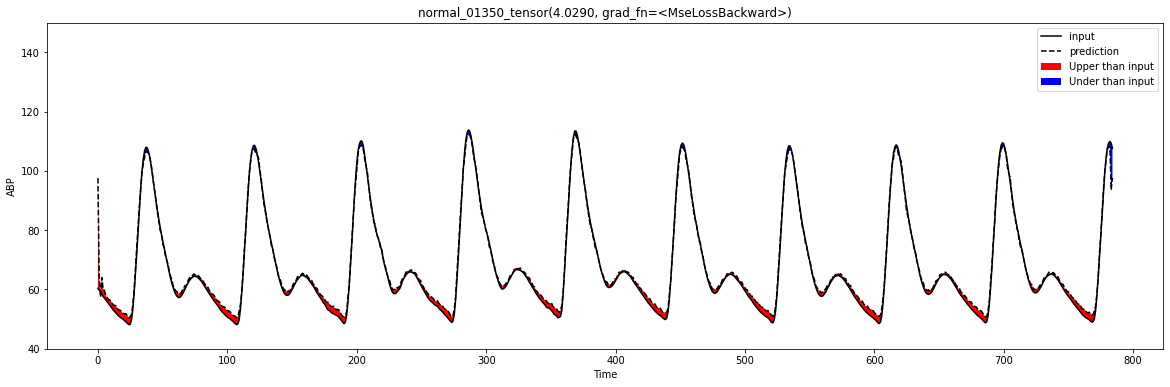

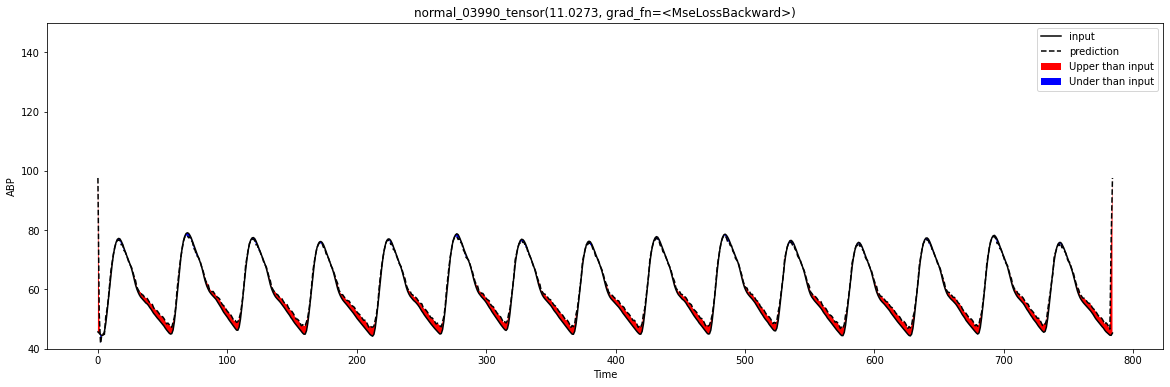

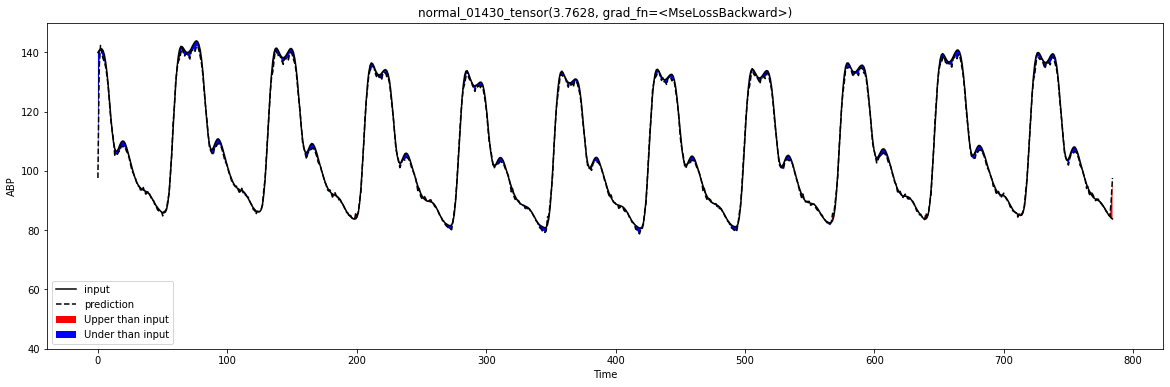

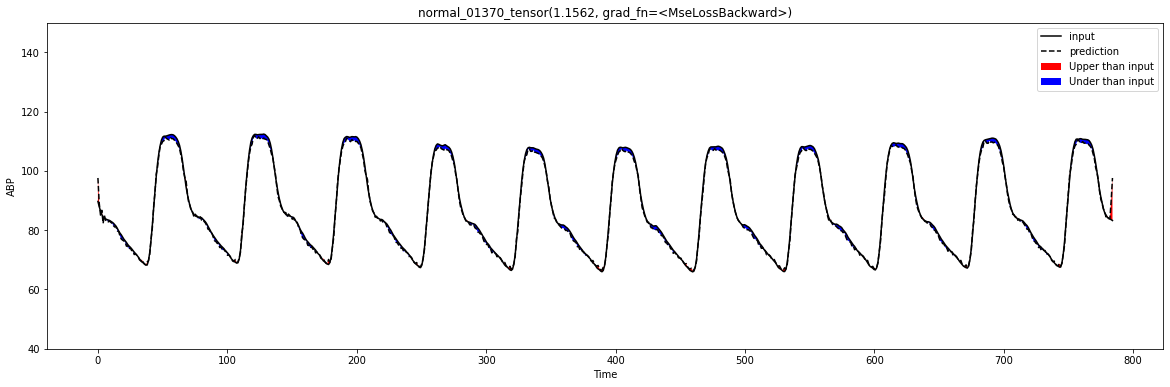

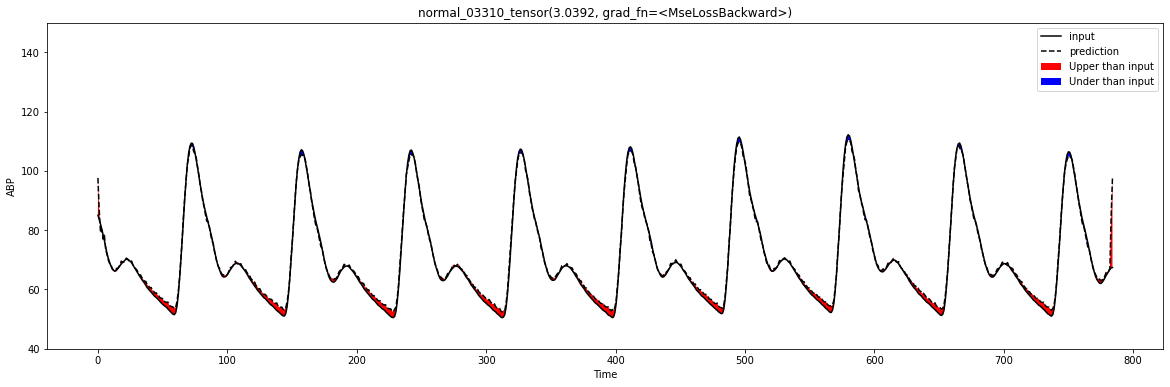

In [38]:
batch = next(iter(train_loader))

wave = batch[0]
label = batch[1]

pred = model(wave)
pred = postprocess(pred)
wave = postprocess(wave)
print(wave.shape,pred.shape)

ANOMALY_SCORE = []
for idx in range(len(pred)):
    mse_value = F.mse_loss(pred[idx][0],wave[idx][0])
    ANOMALY_SCORE.append(mse_value)
    
    fig, ax = plt.subplots(1, 1, sharex=True,figsize=(20,6))
    x = np.linspace(0,pred.shape[-1],pred.shape[-1])
    y1=wave[idx][0].cpu().detach().numpy()
    y2=pred[idx][0].cpu().detach().numpy()
    
    ax.plot(x, y1, color='black',label='input')
    ax.plot(x, y2, color='black', linestyle='dashed',label='prediction')
    ax.set_title(label[idx]+'_'+str(mse_value))
    ax.set(ylim=(40,150))
    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='red', interpolate=True,label='Upper than input')
    ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='blue', interpolate=True,label='Under than input')
    ax.set_ylabel('ABP')
    ax.set_xlabel('Time')
    ax.legend()

ANOMALY_SCORE = torch.tensor(ANOMALY_SCORE)
print(ANOMALY_SCORE.mean(),ANOMALY_SCORE.max(),ANOMALY_SCORE.min(),ANOMALY_SCORE.median())

torch.Size([32, 1, 784]) torch.Size([32, 1, 784])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


tensor(4.8312) tensor(8.1277) tensor(2.0947) tensor(4.4735)


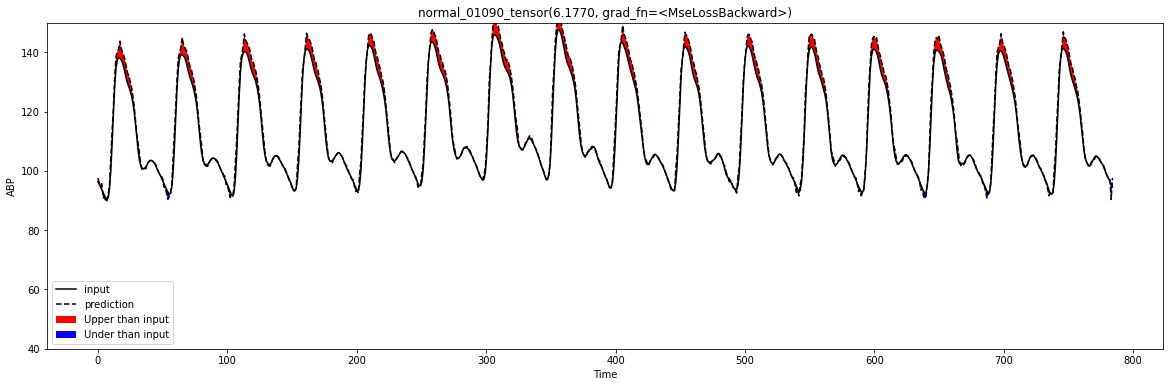

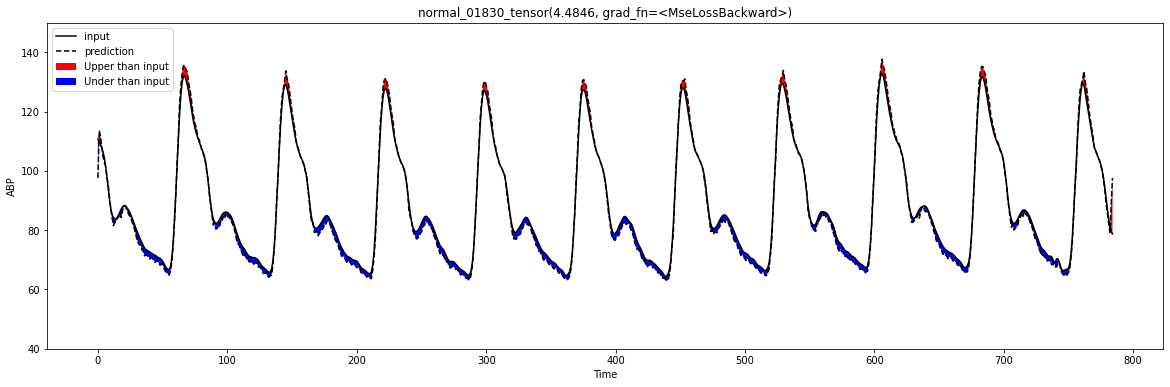

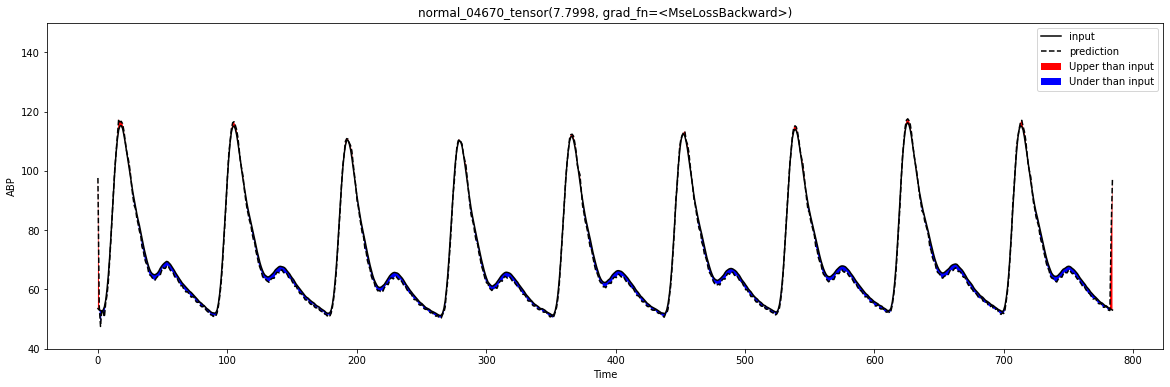

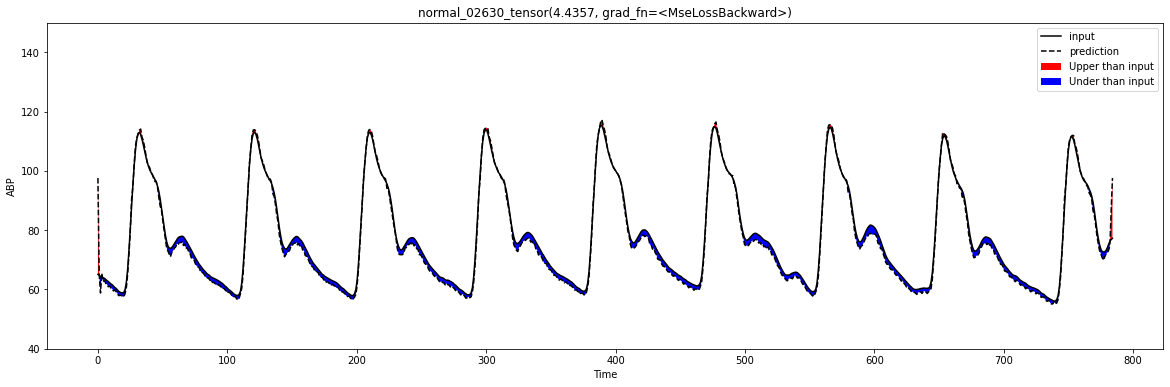

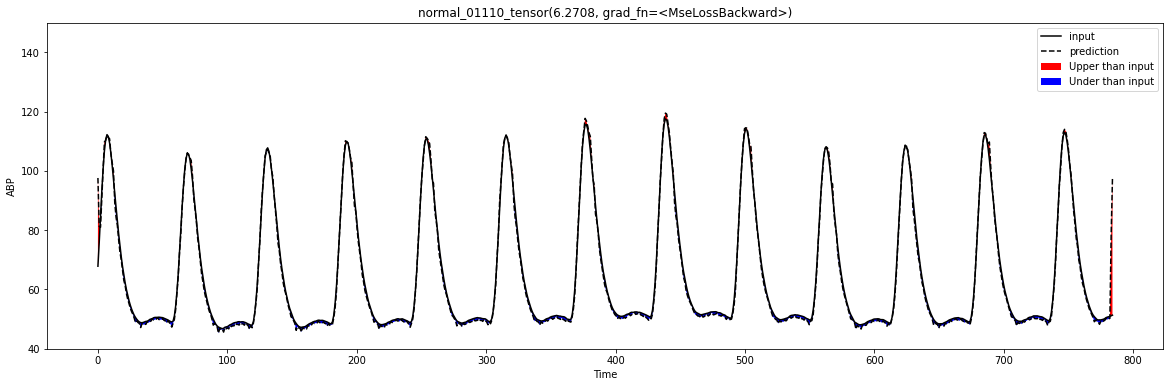

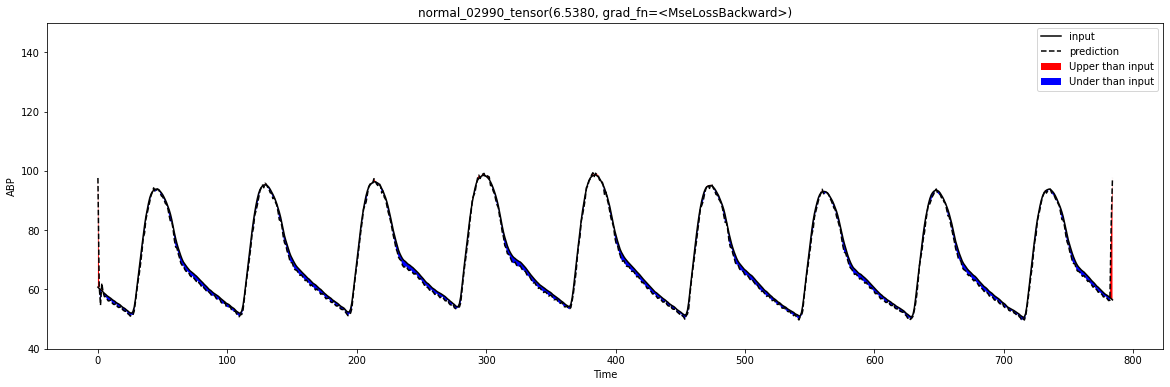

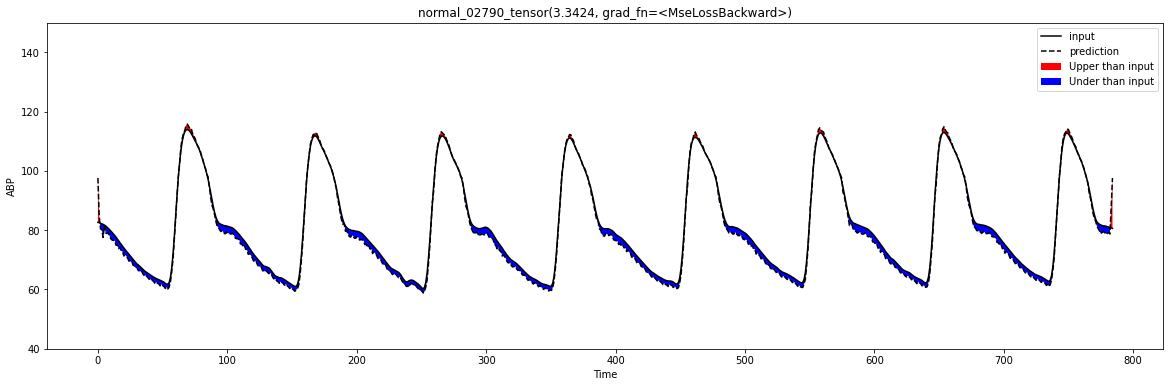

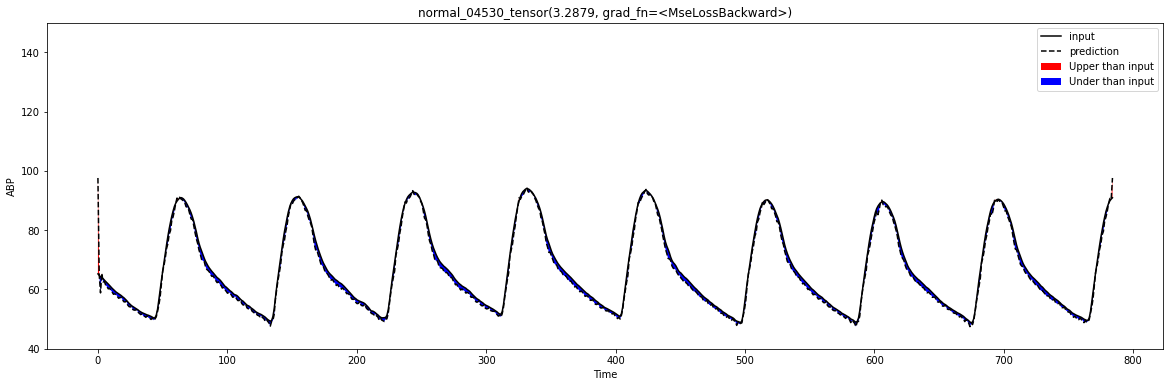

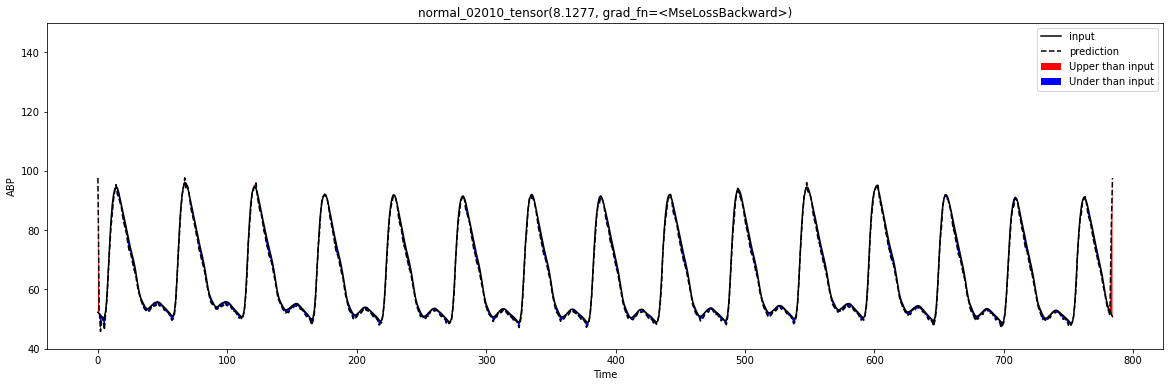

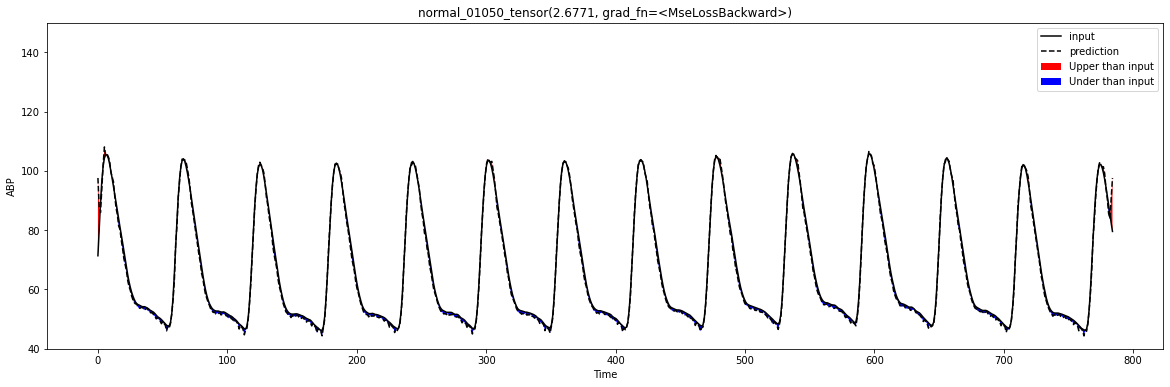

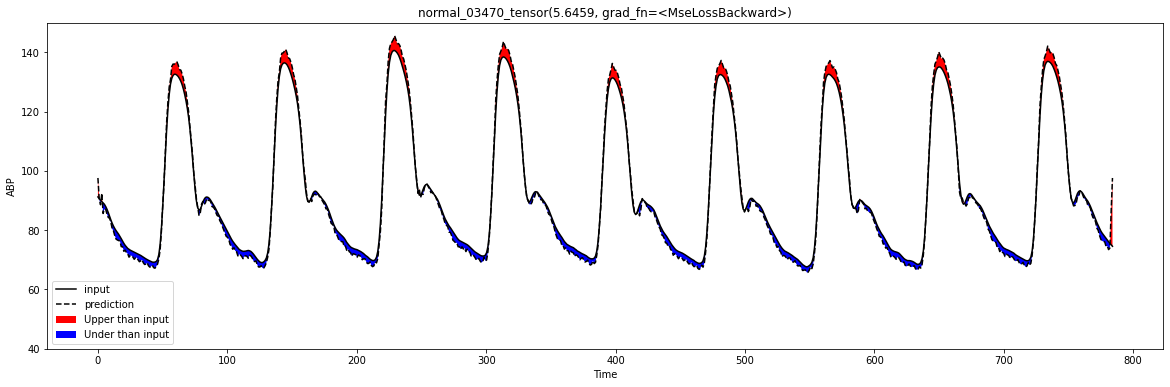

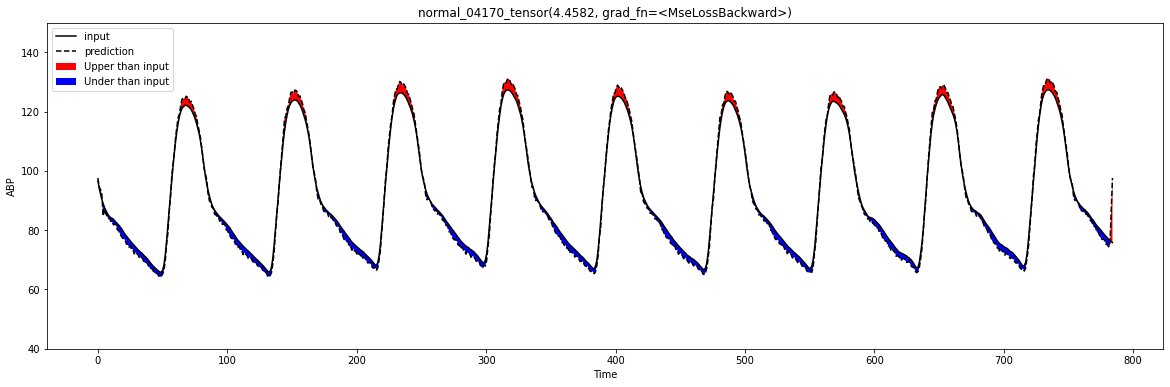

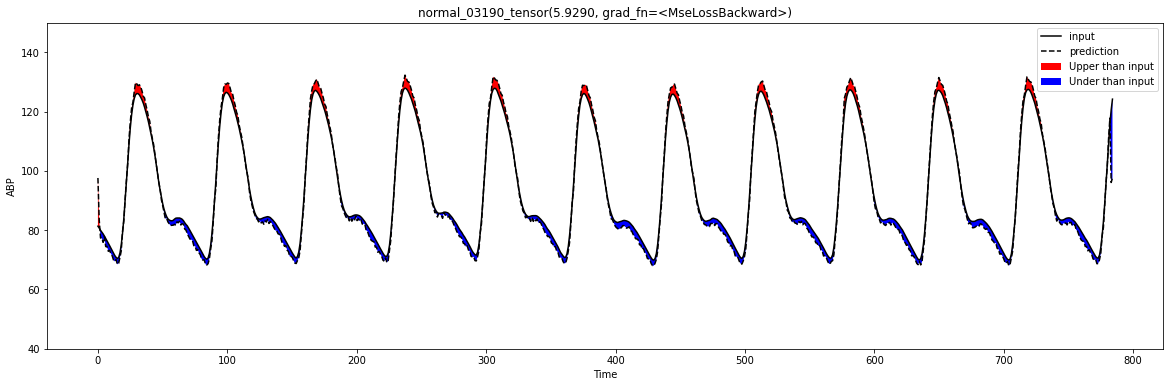

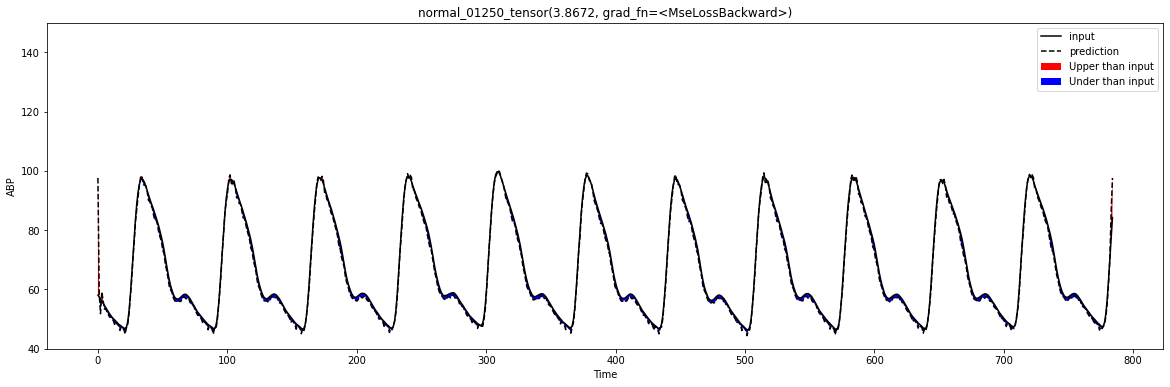

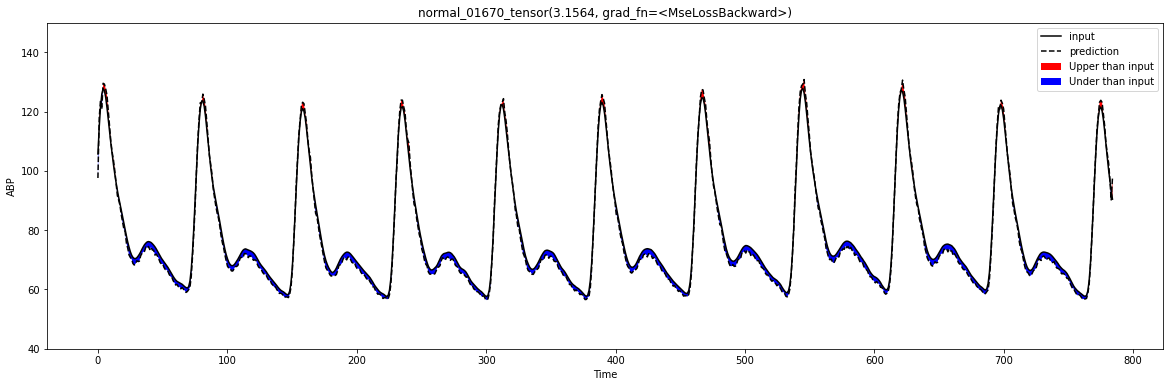

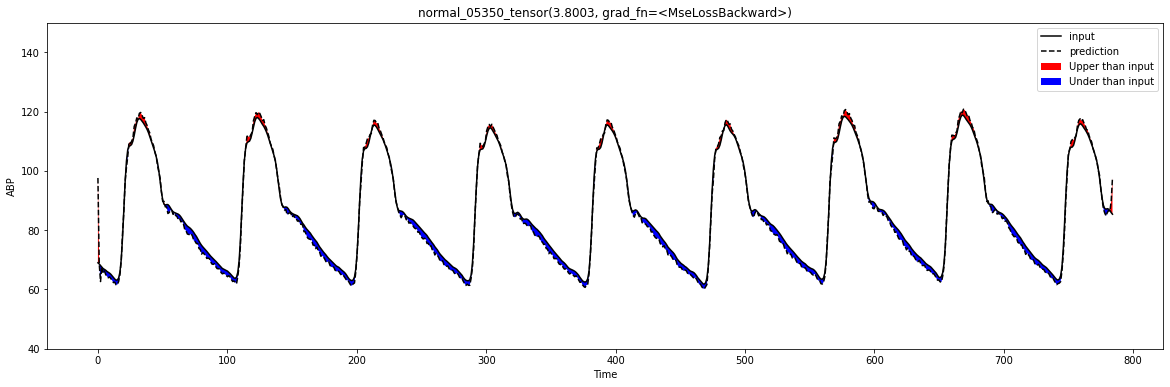

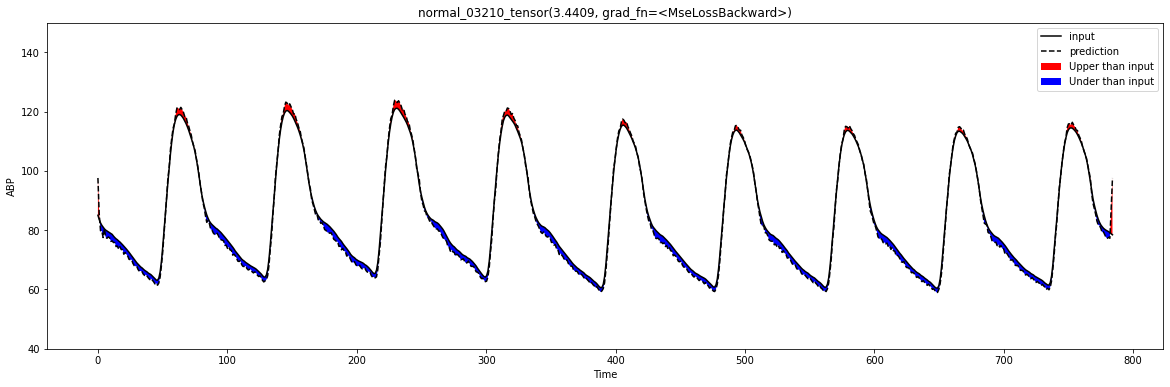

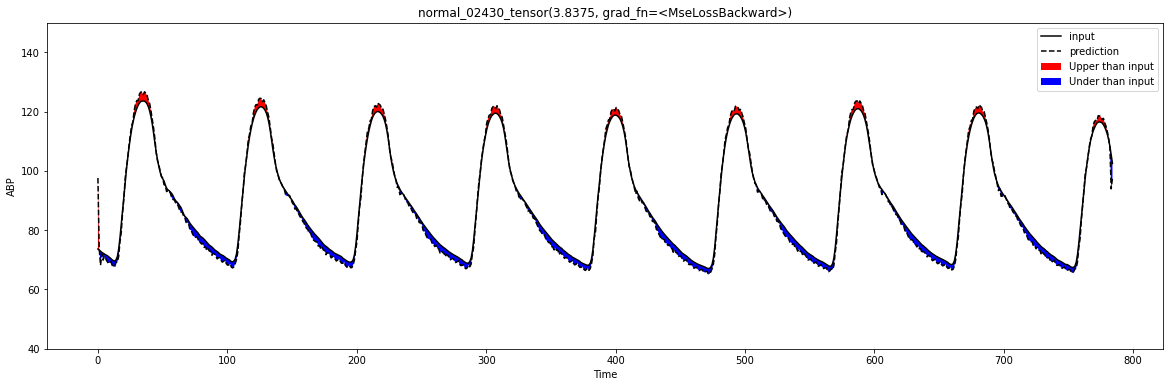

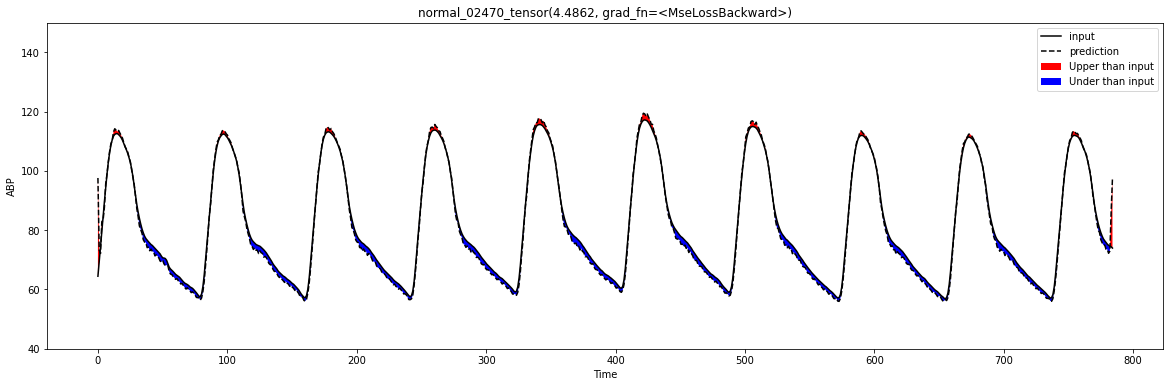

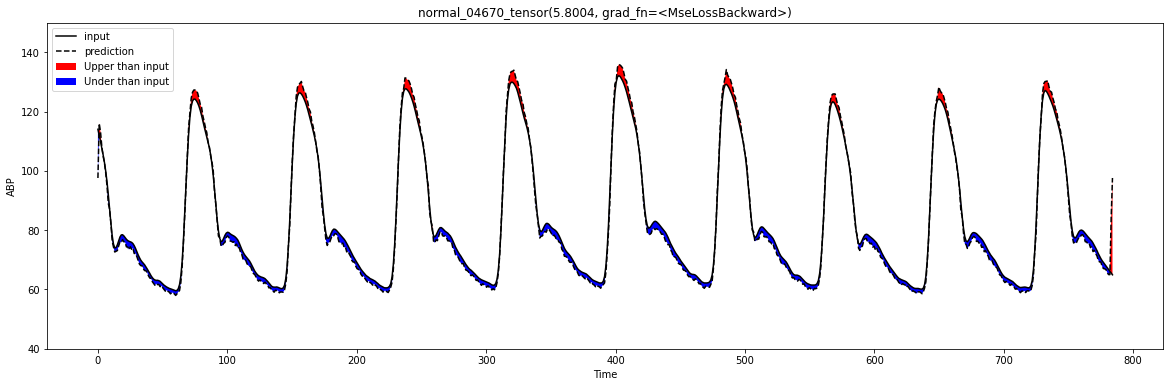

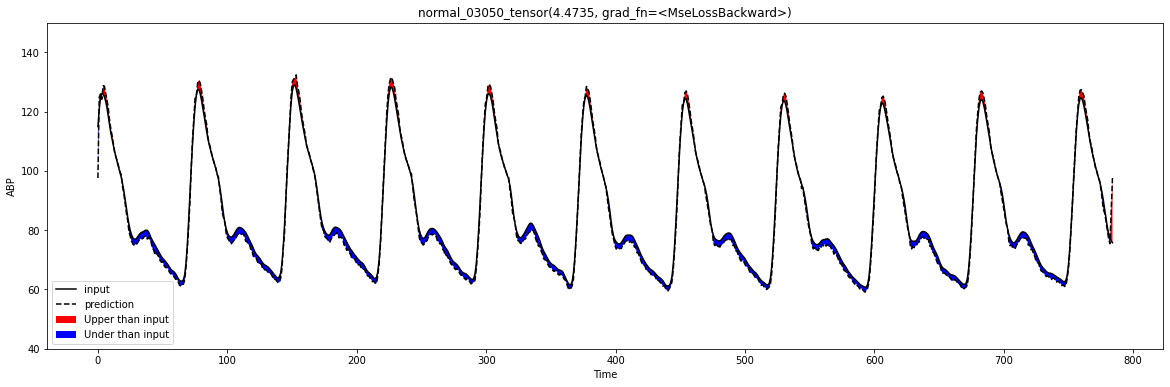

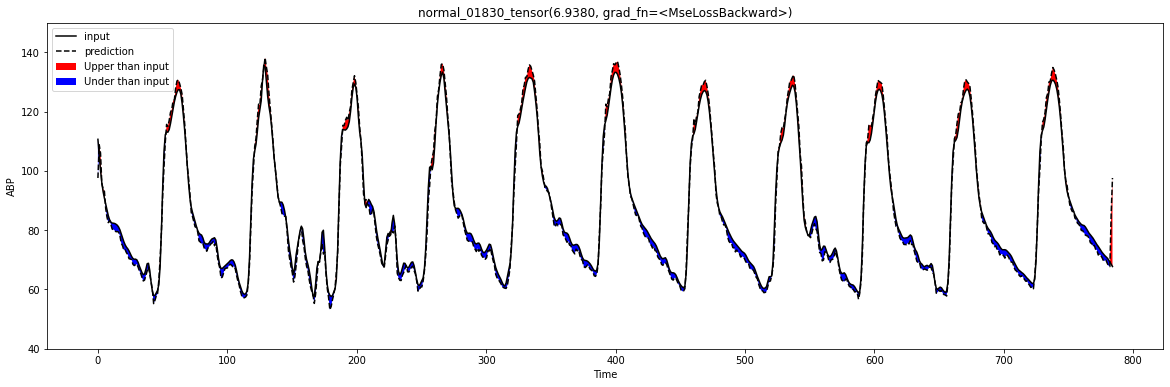

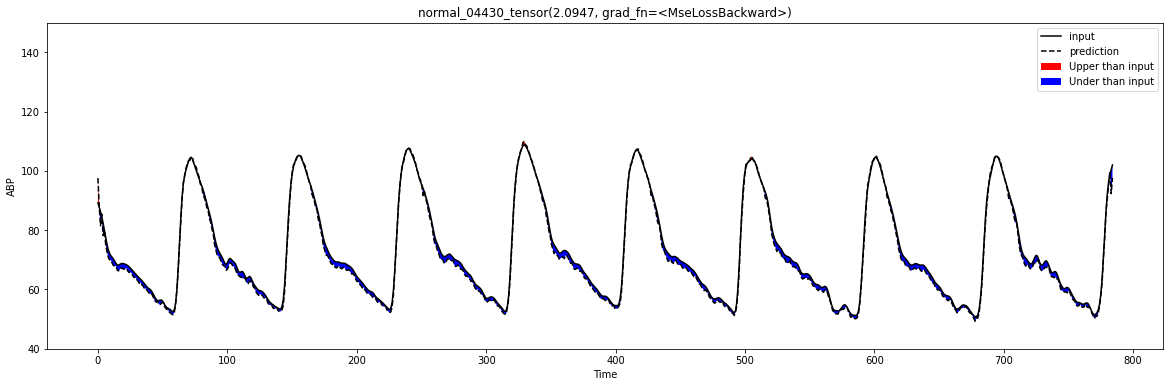

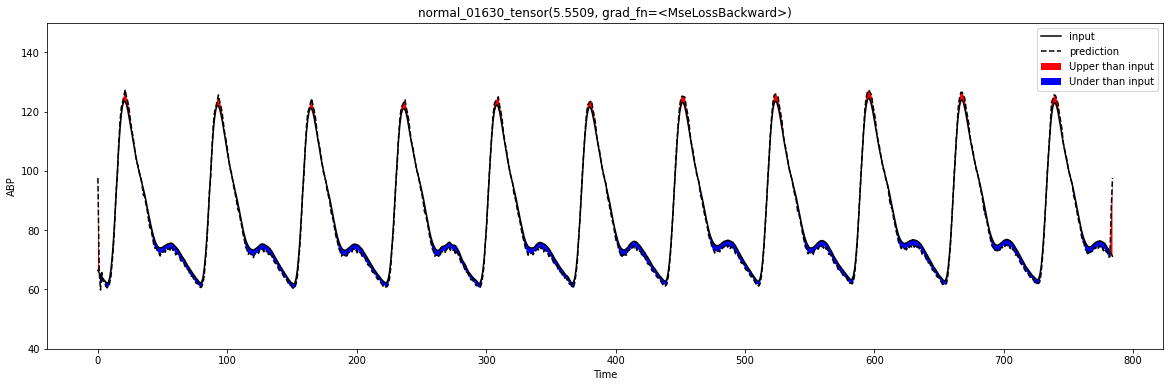

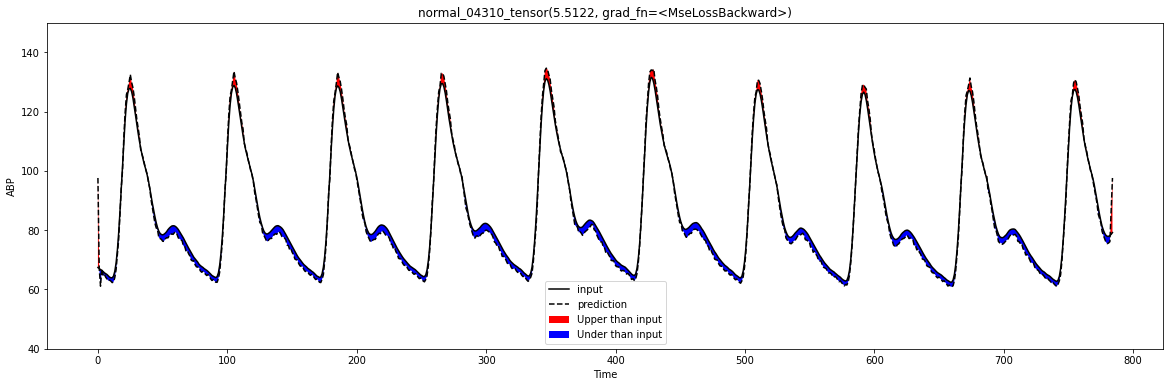

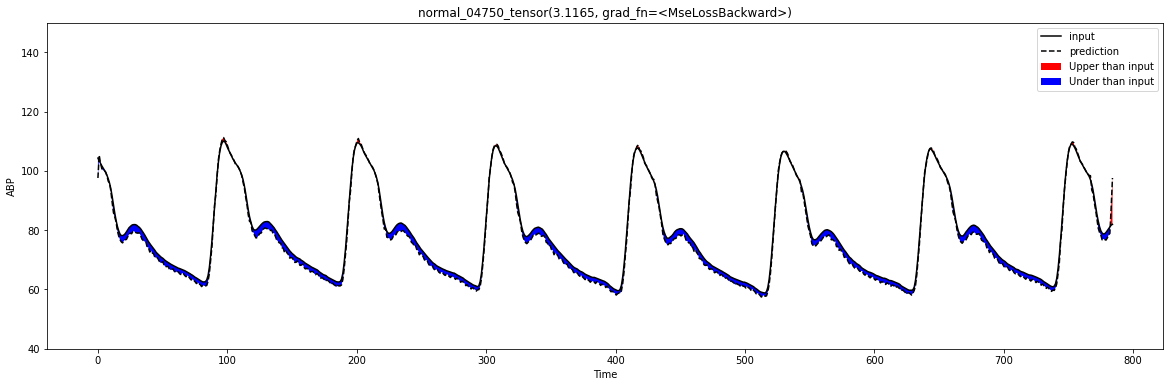

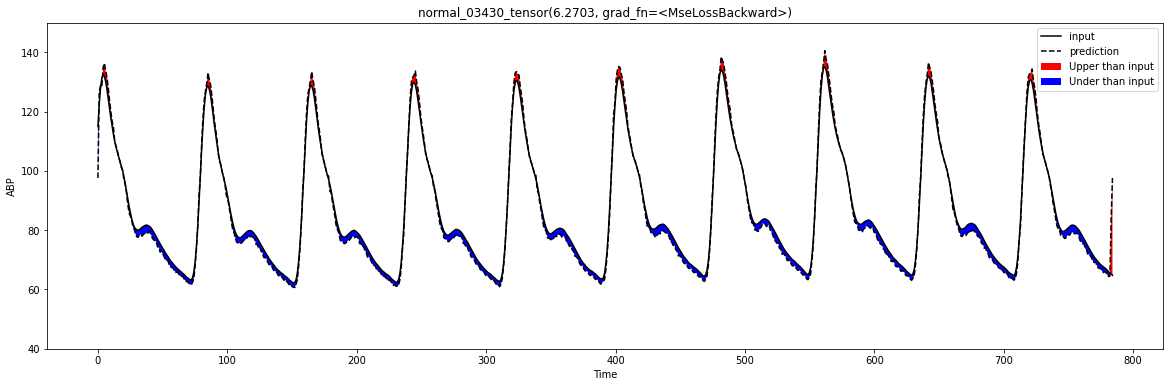

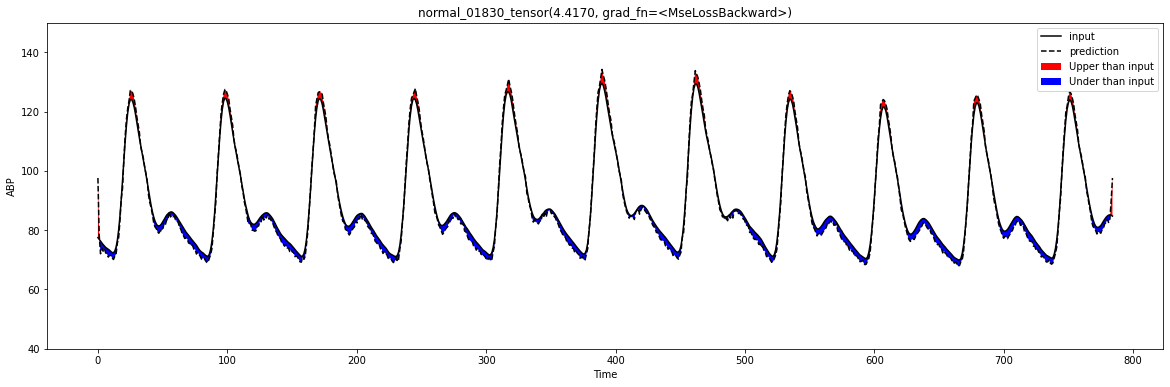

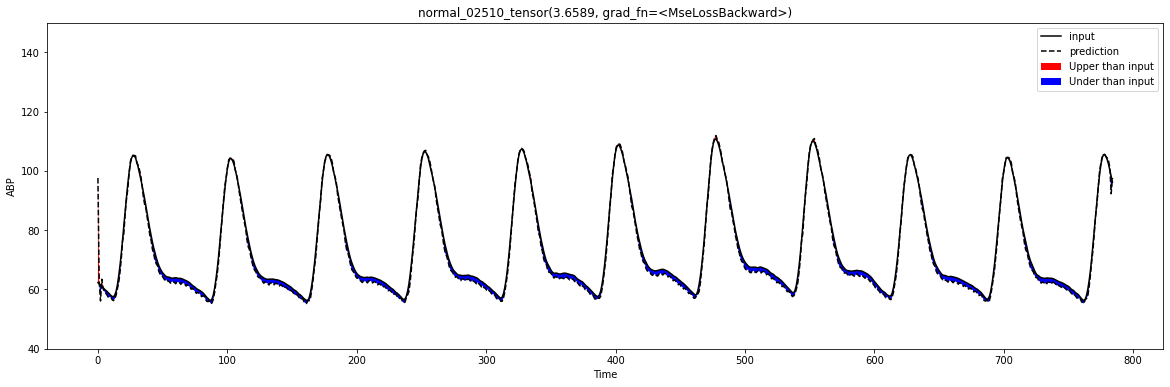

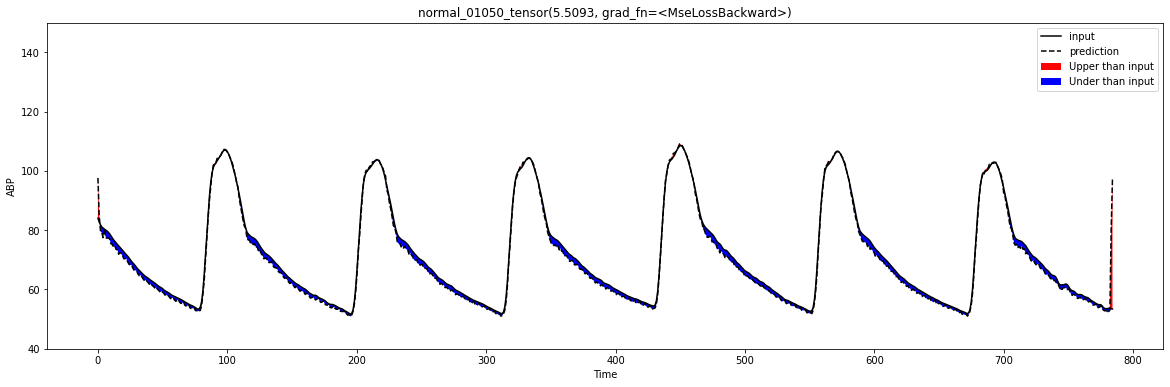

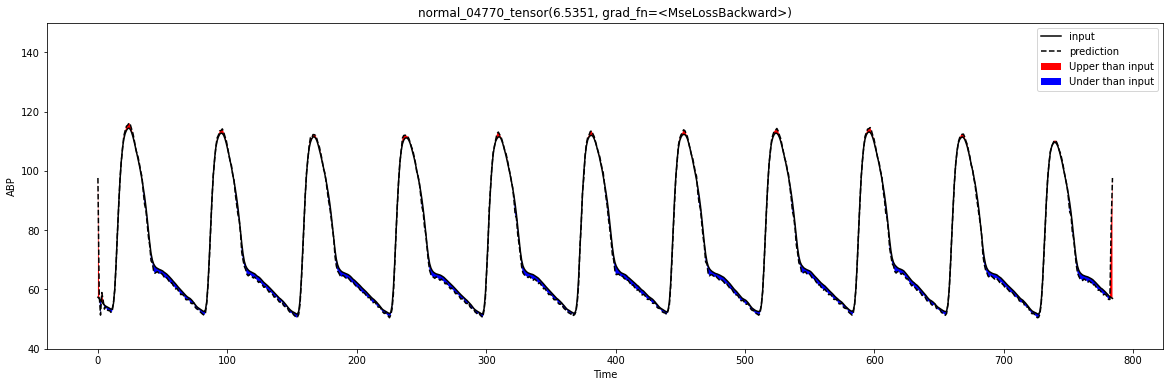

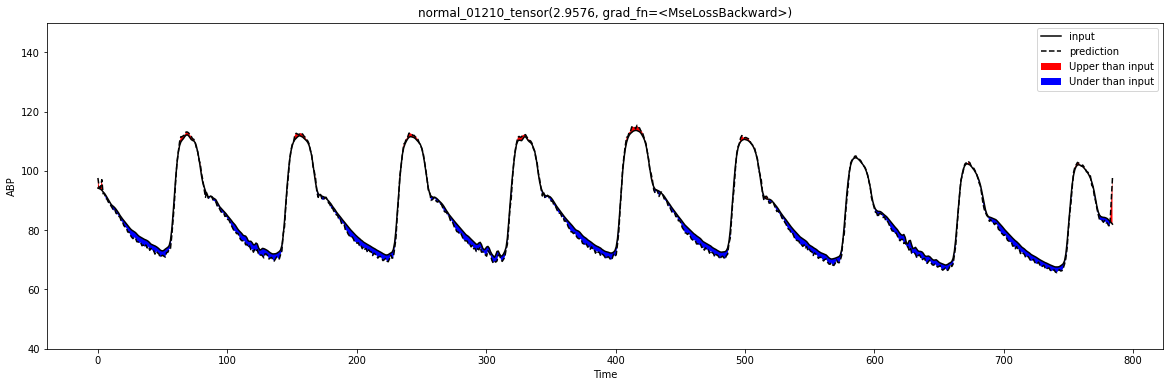

In [39]:
batch = next(iter(test_loader_normal))
wave = batch[0]
label = batch[1]

pred = model(wave)
pred = postprocess(pred)
wave = postprocess(wave)
print(wave.shape,pred.shape)

ANOMALY_SCORE = []
for idx in range(len(pred)):
    mse_value = F.mse_loss(pred[idx][0],wave[idx][0])
    ANOMALY_SCORE.append(mse_value)
    
    fig, ax = plt.subplots(1, 1, sharex=True,figsize=(20,6))
    x = np.linspace(0,pred.shape[-1],pred.shape[-1])
    y1=wave[idx][0].cpu().detach().numpy()
    y2=pred[idx][0].cpu().detach().numpy()
    
    ax.plot(x, y1, color='black',label='input')
    ax.plot(x, y2, color='black', linestyle='dashed',label='prediction')
    ax.set_title(label[idx]+'_'+str(mse_value))
    ax.set(ylim=(40,150))
    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='red', interpolate=True,label='Upper than input')
    ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='blue', interpolate=True,label='Under than input')
    ax.set_ylabel('ABP')
    ax.set_xlabel('Time')
    ax.legend()
    
ANOMALY_SCORE = torch.tensor(ANOMALY_SCORE)
print(ANOMALY_SCORE.mean(),ANOMALY_SCORE.max(),ANOMALY_SCORE.min(),ANOMALY_SCORE.median())

torch.Size([32, 1, 784]) torch.Size([32, 1, 784])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


tensor(45.2162) tensor(81.1149) tensor(23.4189) tensor(40.0684)


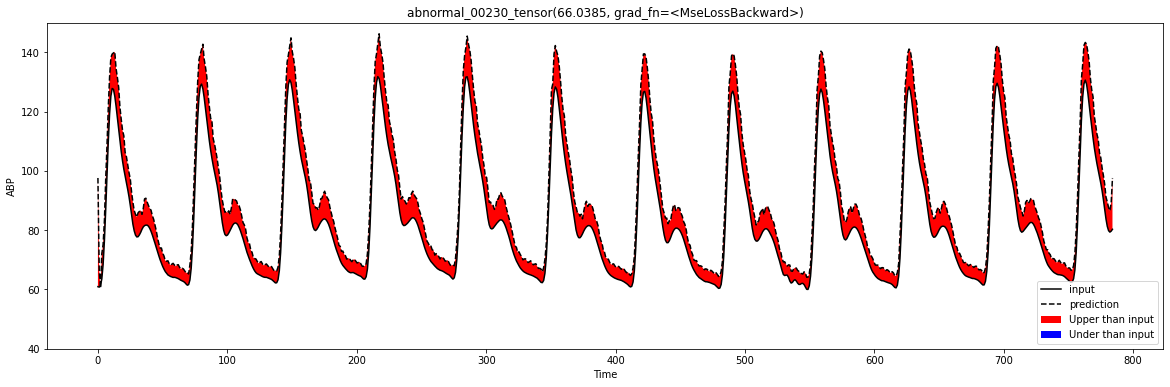

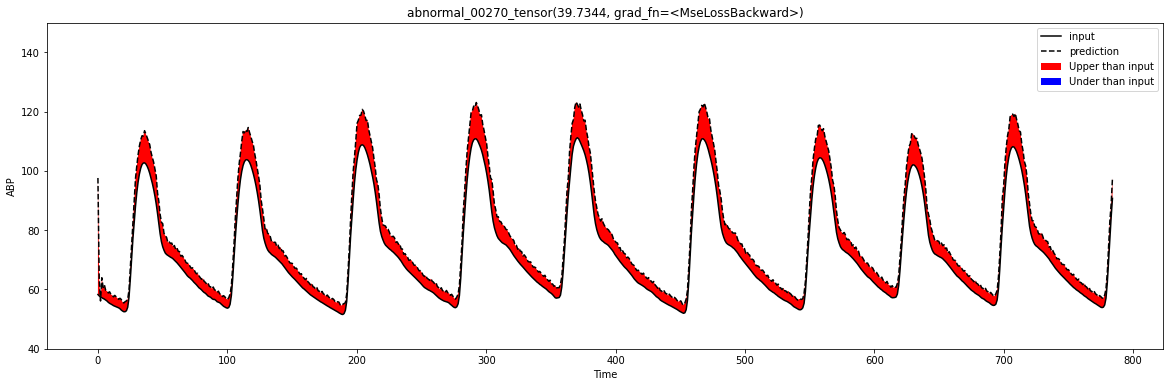

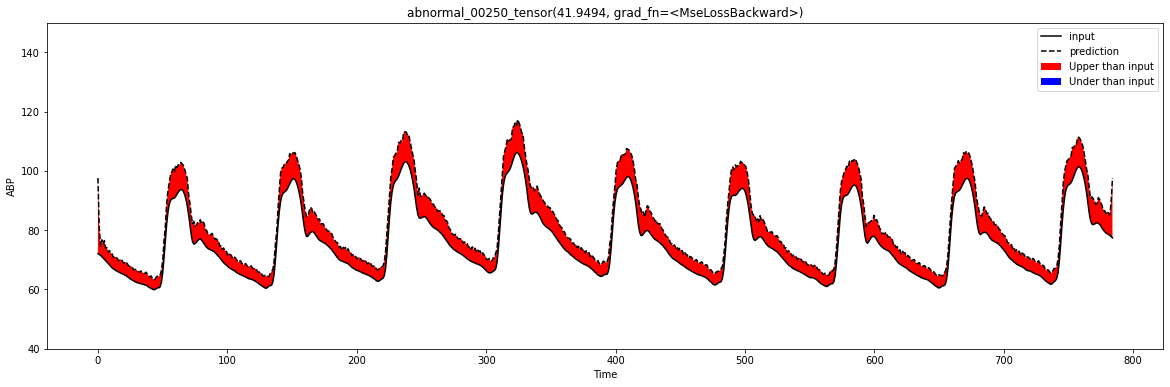

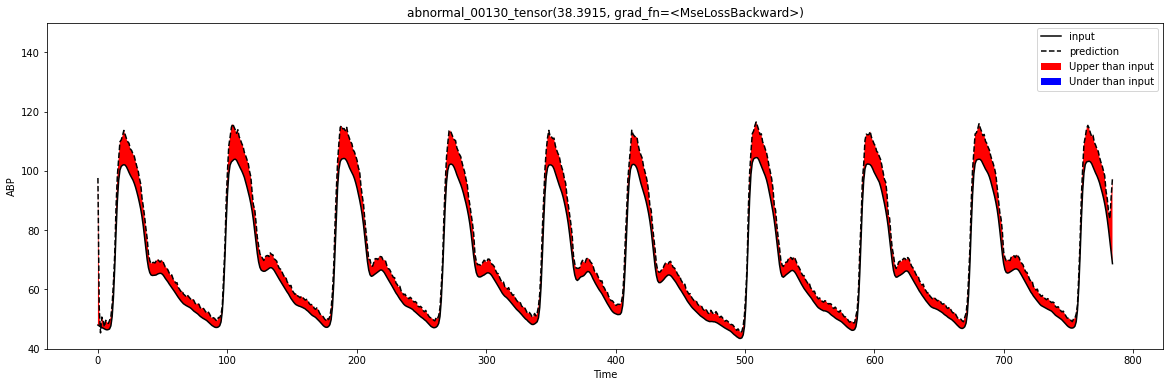

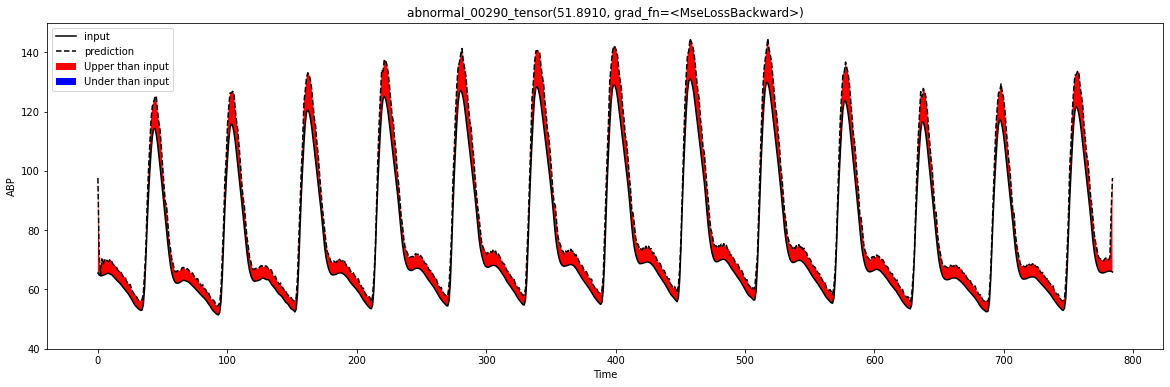

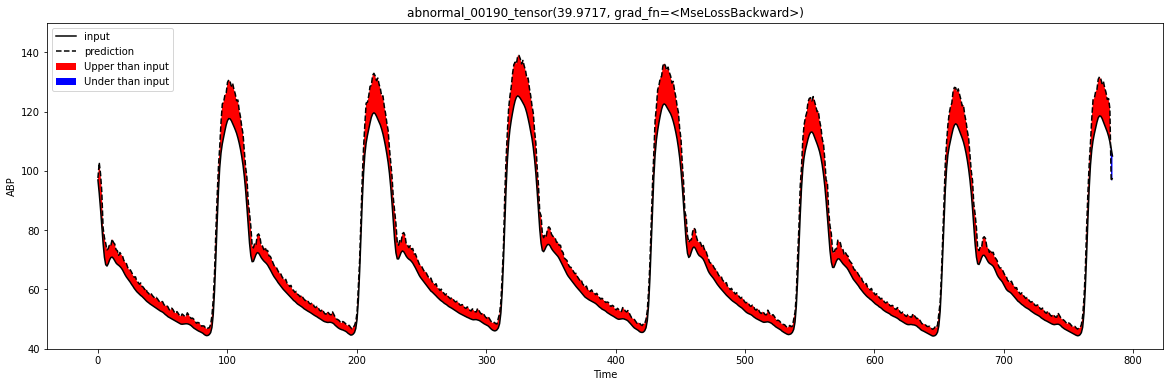

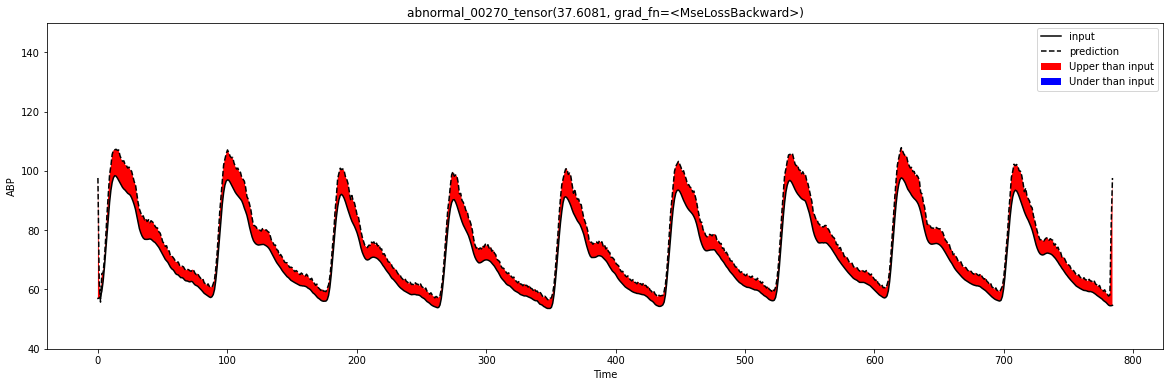

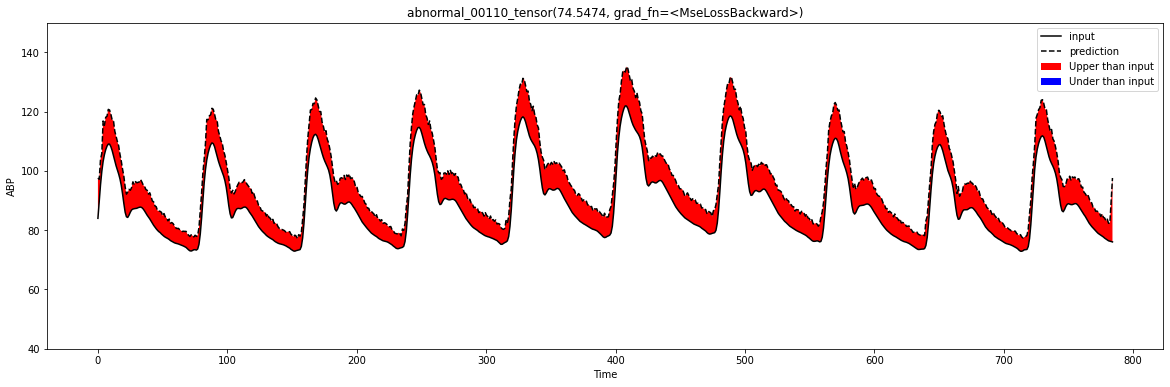

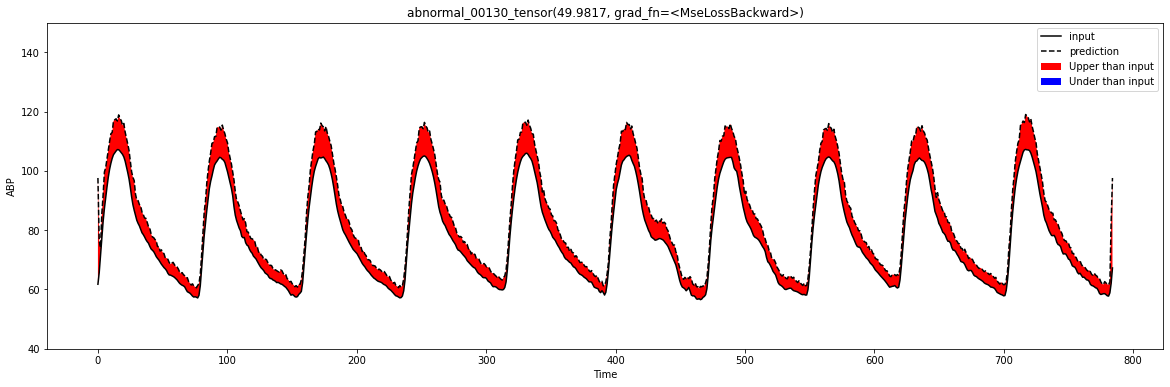

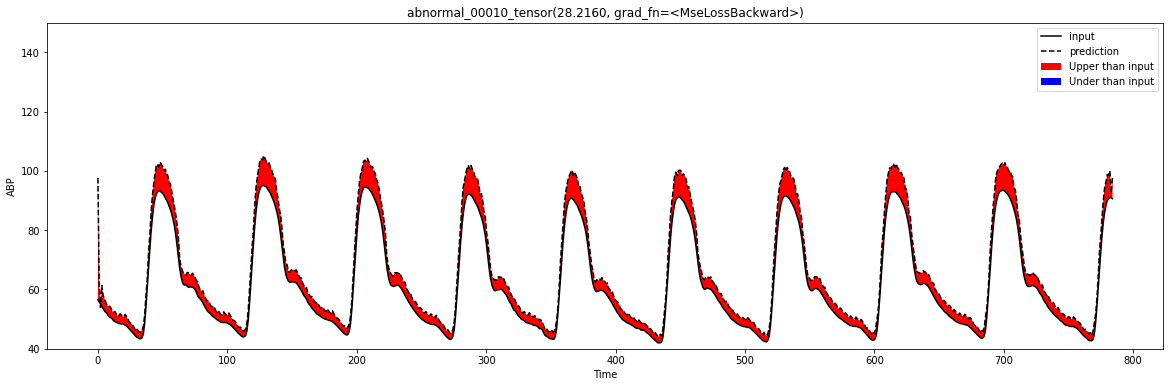

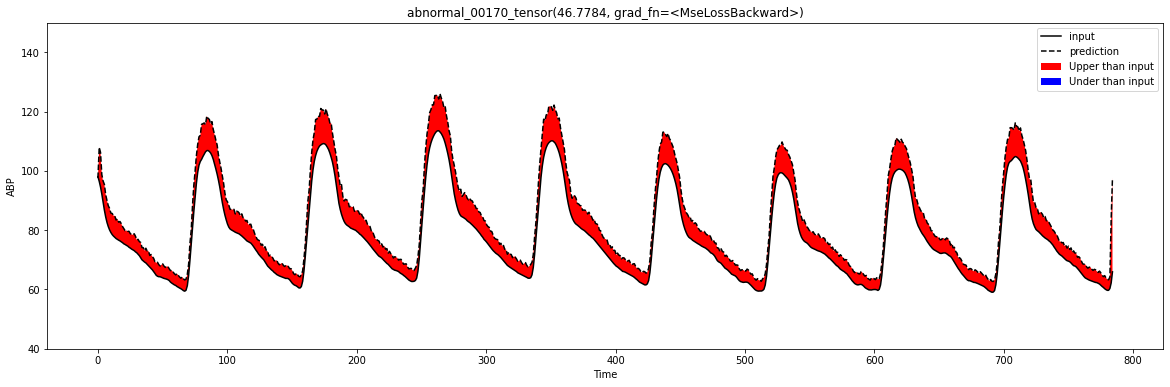

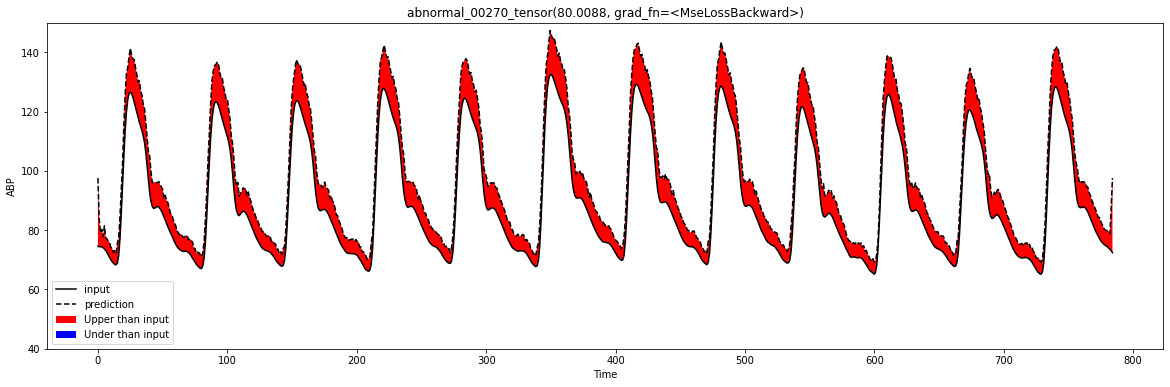

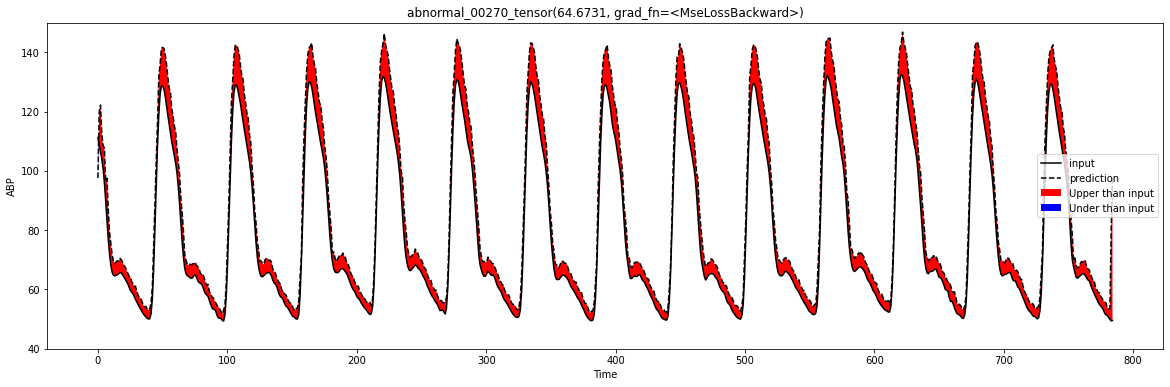

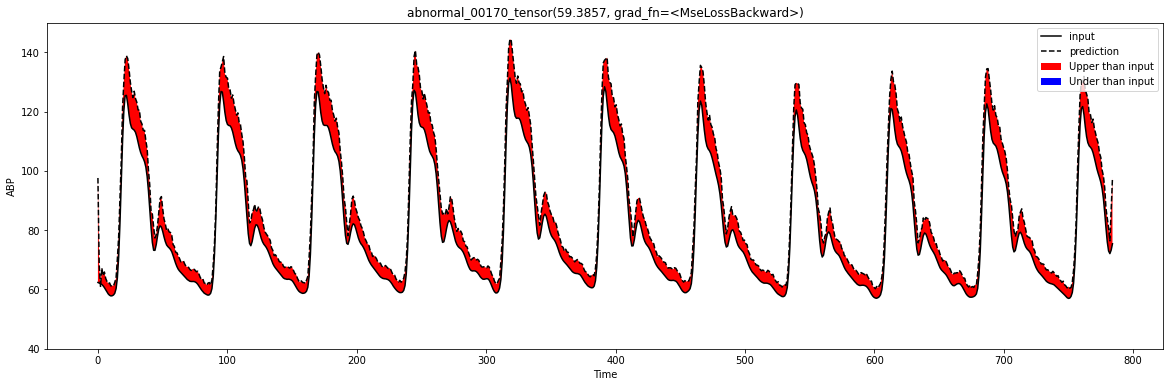

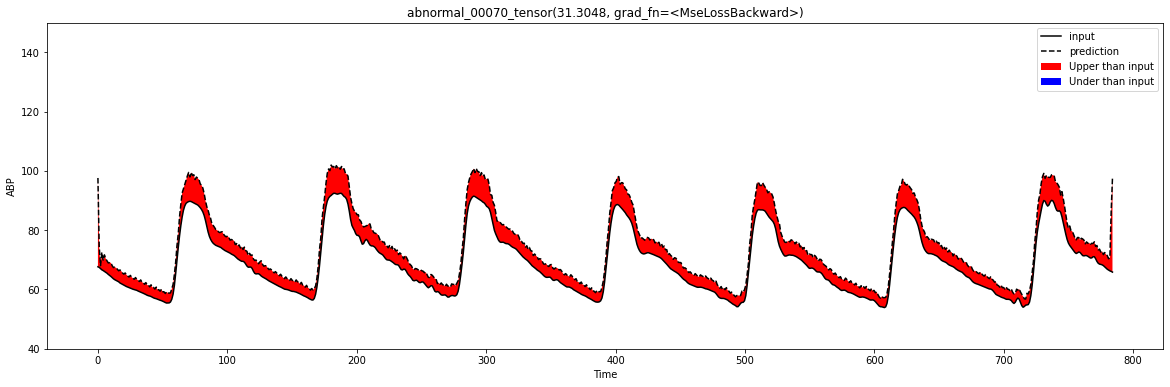

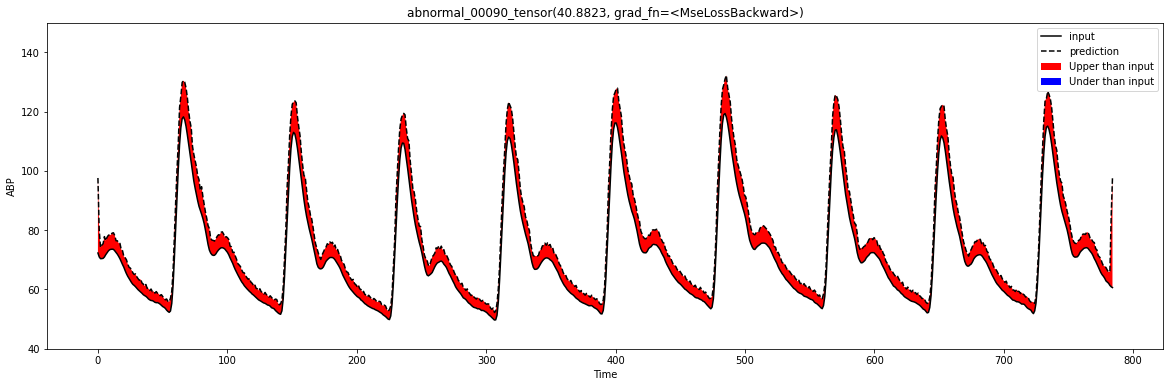

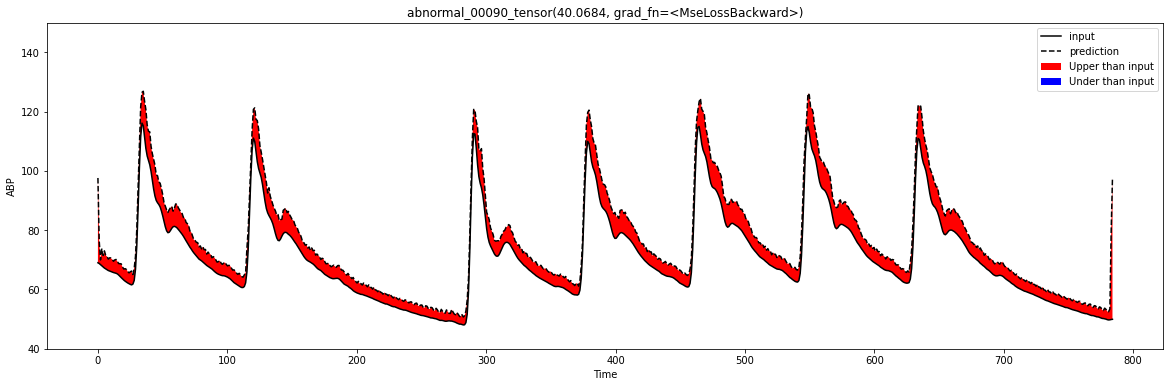

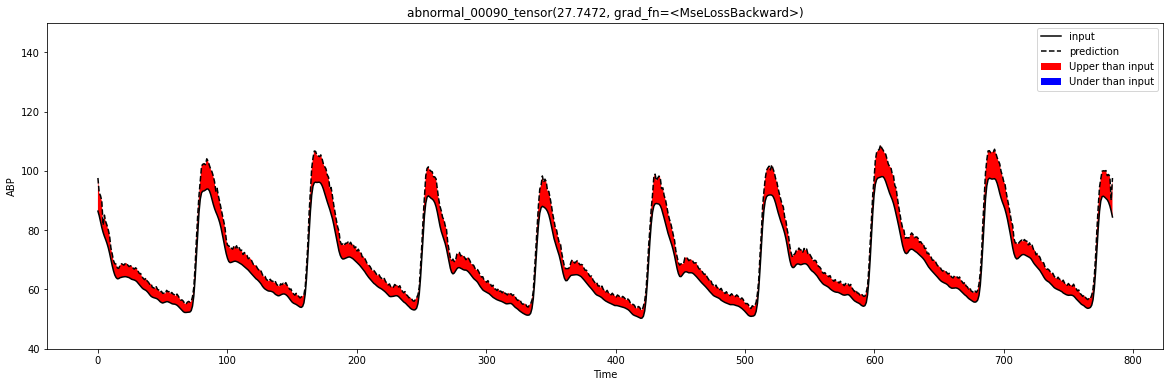

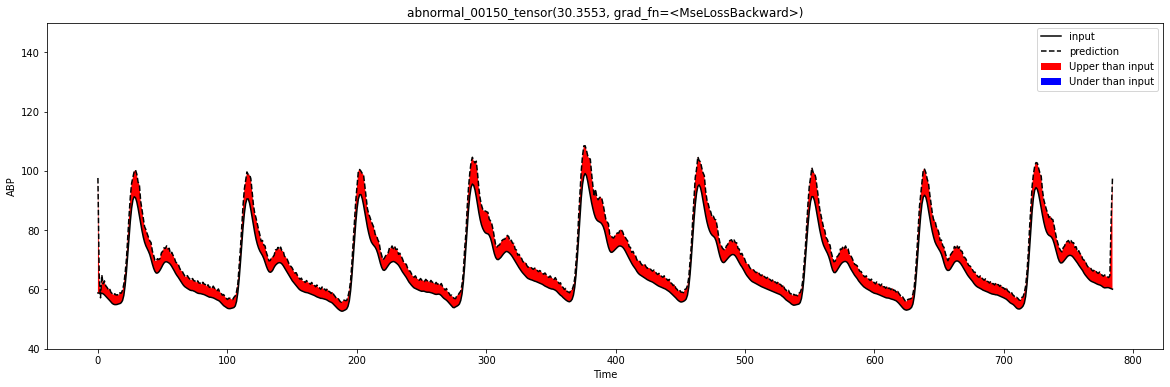

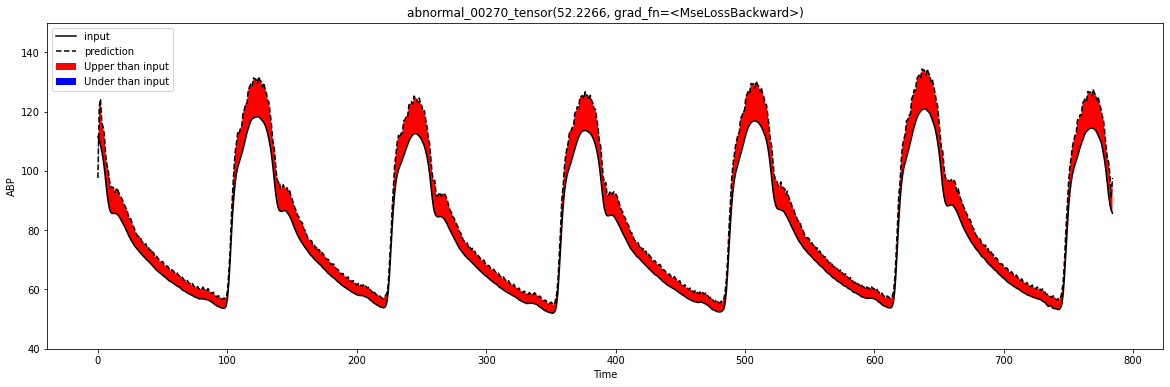

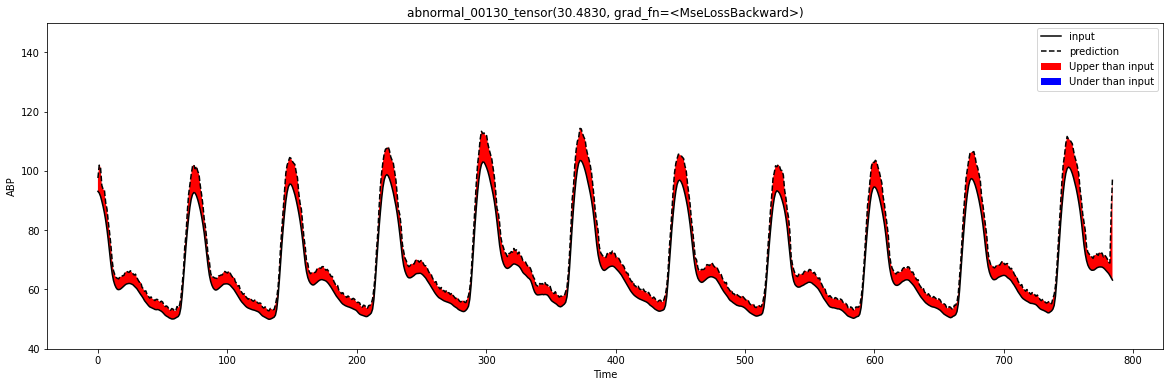

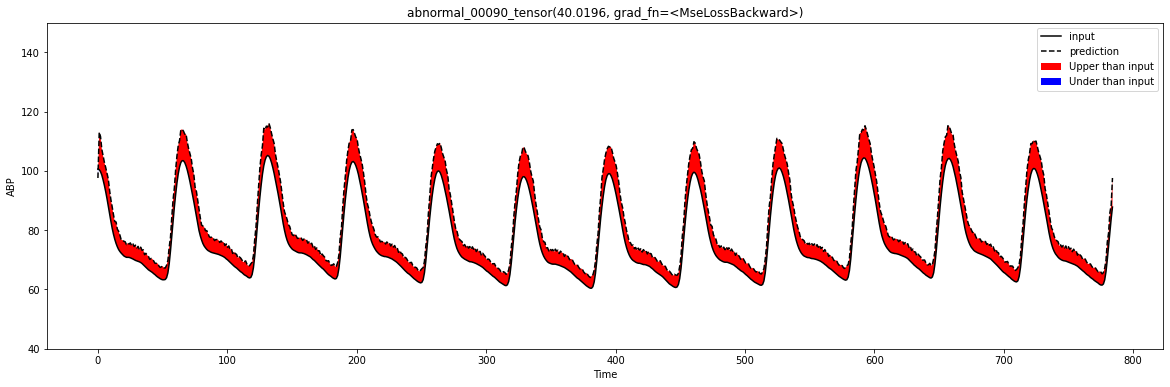

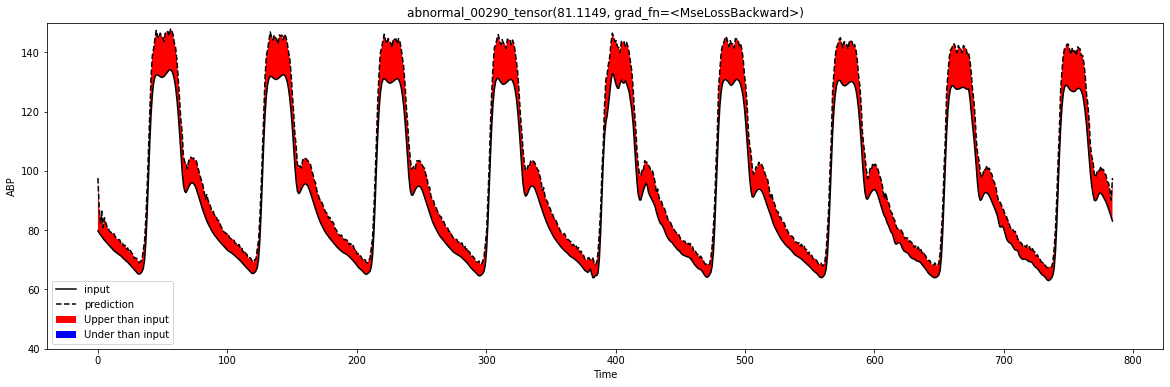

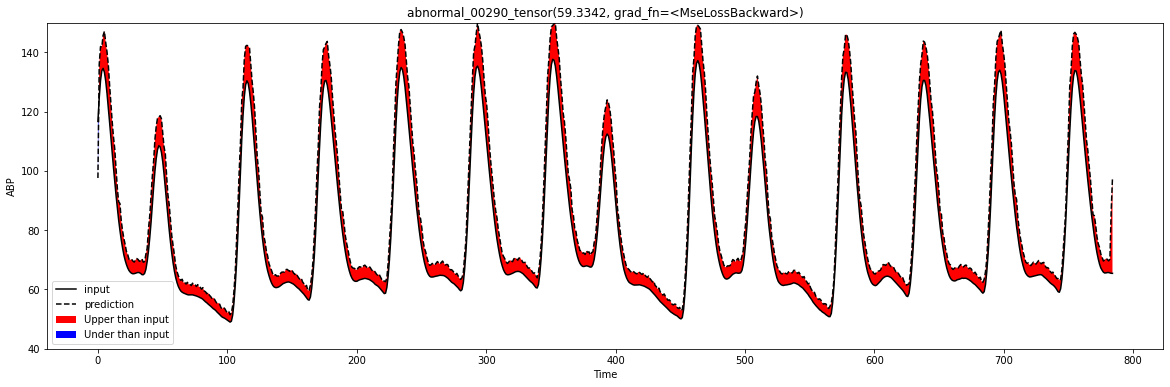

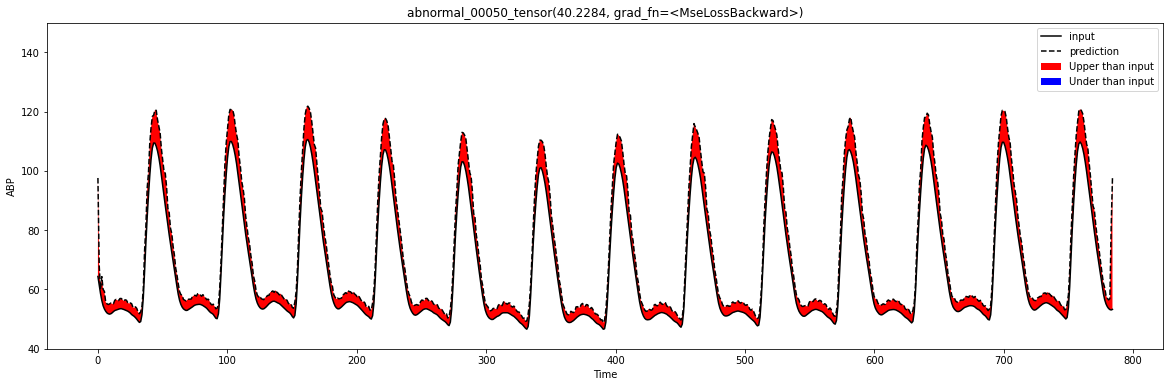

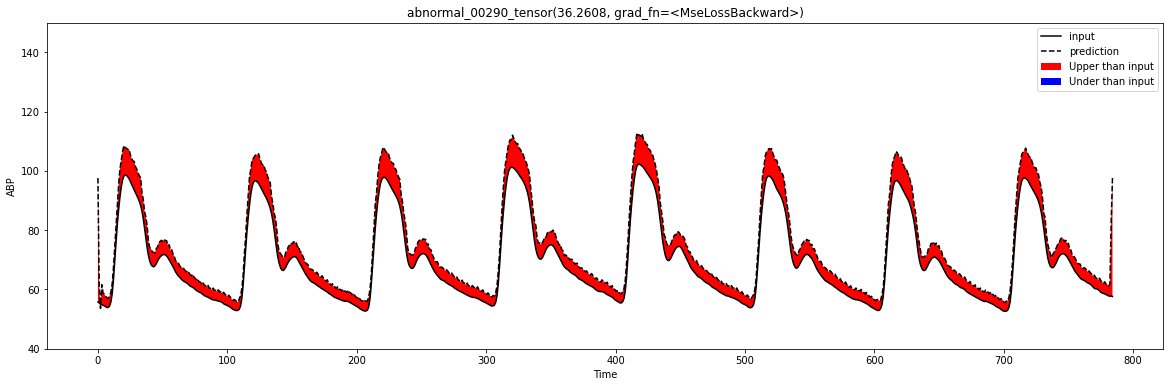

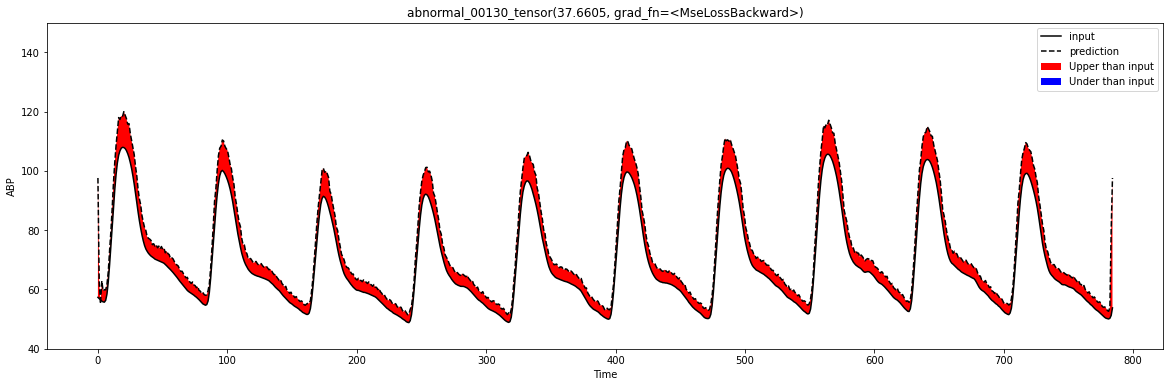

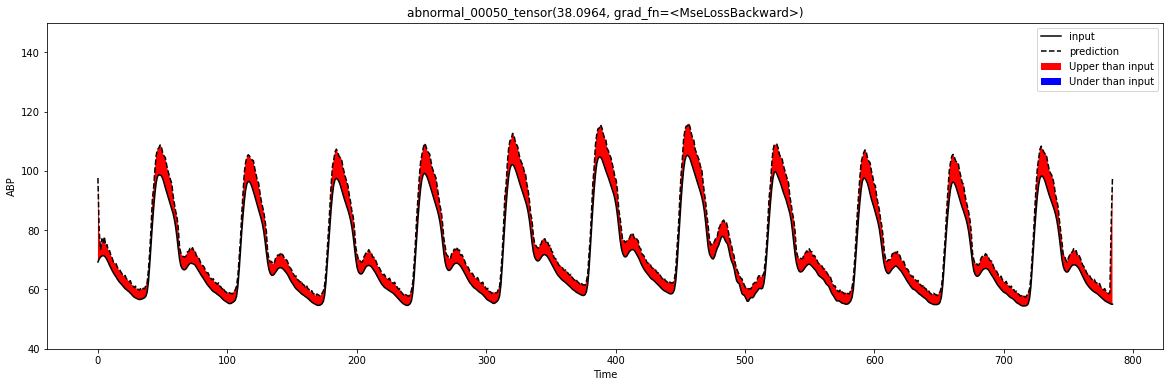

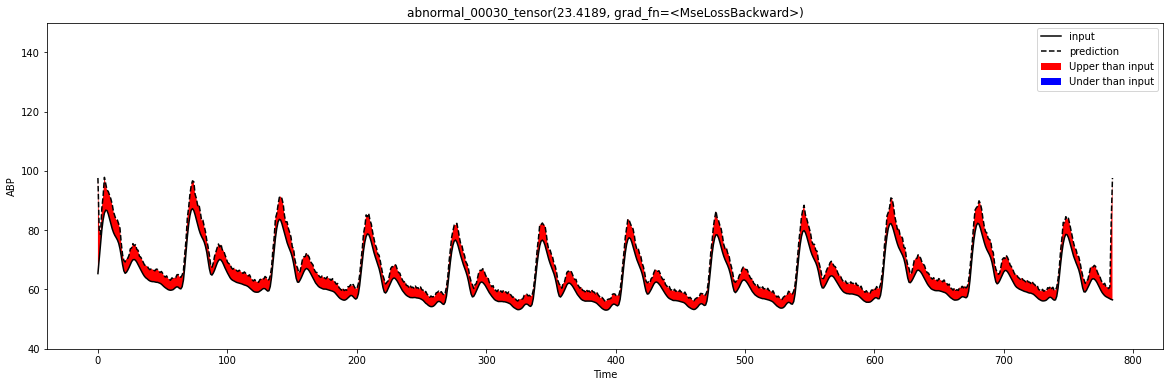

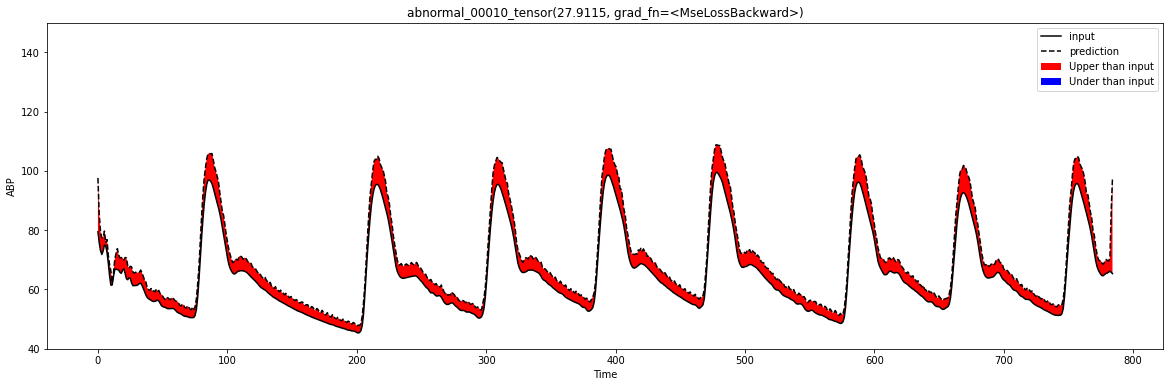

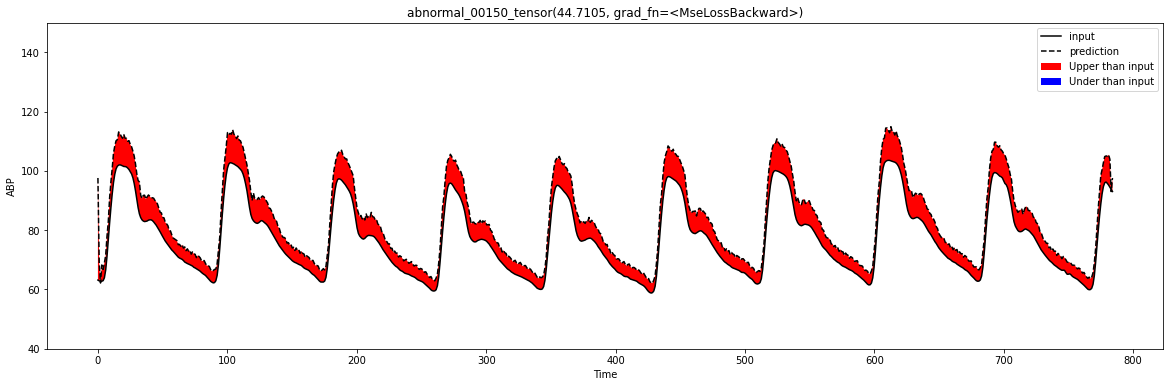

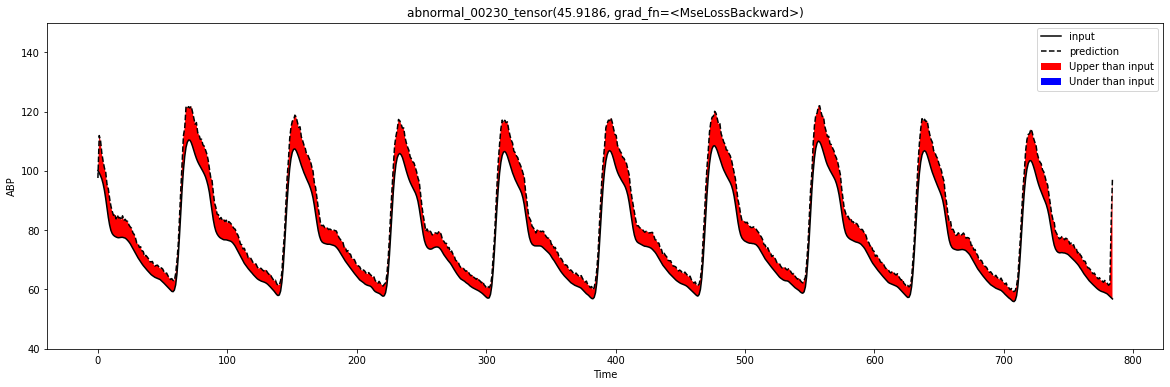

In [40]:
batch = next(iter(test_loader_abnormal))
wave = batch[0]
label = batch[1]

pred = model(wave)
pred = postprocess(pred)
wave = postprocess(wave)
print(wave.shape,pred.shape)


ANOMALY_SCORE = []
for idx in range(len(pred)):
    mse_value = F.mse_loss(pred[idx][0],wave[idx][0])
    ANOMALY_SCORE.append(mse_value)
    
    fig, ax = plt.subplots(1, 1, sharex=True,figsize=(20,6))
    x = np.linspace(0,pred.shape[-1],pred.shape[-1])
    y1=wave[idx][0].cpu().detach().numpy()
    y2=pred[idx][0].cpu().detach().numpy()
    
    ax.plot(x, y1, color='black',label='input')
    ax.plot(x, y2, color='black', linestyle='dashed',label='prediction')
    ax.set_title(label[idx]+'_'+str(mse_value))
    ax.set(ylim=(40,150))
    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='red', interpolate=True,label='Upper than input')
    ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='blue', interpolate=True,label='Under than input')
    ax.set_ylabel('ABP')
    ax.set_xlabel('Time')
    ax.legend()

# #     plt.title(label[idx]+'_'+str(mse_value))
#     plt.plot(wave[idx][0].cpu().detach().numpy(),label='input')
#     plt.plot(pred[idx][0].cpu().detach().numpy(),label='output')
#     plt.legend()
    
ANOMALY_SCORE = torch.tensor(ANOMALY_SCORE)
print(ANOMALY_SCORE.mean(),ANOMALY_SCORE.max(),ANOMALY_SCORE.min(),ANOMALY_SCORE.median())
ANOMALY_SCORE_threshold = 40 

# # GT = []
# # RESULT =[]
# for idx in range(len(ANOMALY_SCORE)):
#     GT.append([1])
#     if ANOMALY_SCORE[idx]<ANOMALY_SCORE_threshold:
#         RESULT.append([0])
#     else:
#         RESULT.append([1])
        
# GT = np.array(GT)
# RESULT = np.array(RESULT)
# plt.figure()
# plt.hist(RESULT)

In [41]:
ANOMALY_SCORE = []
NORMAL=[]
ABNORMAL=[]
NORMAL_LOWSCORE = []
ABNORMAL_HIGHSCORE = []
ANOMALY_SCORE_threshold = 40

for batch_idx, (wave, label) in enumerate(test_loader):
    
    pred = model(wave)
    pred = postprocess(pred)
    wave = postprocess(wave)

    for idx in range(len(pred)):
        mse_value = criterion(pred[idx],wave[idx])
        ANOMALY_SCORE.append(mse_value)
        
        if label[idx].split('_')[0]=='normal':
            NORMAL.append([mse_value])
            if mse_value > ANOMALY_SCORE_threshold:
                NORMAL_LOWSCORE.append(label[idx])
        else:
            ABNORMAL.append([mse_value])
            if mse_value < ANOMALY_SCORE_threshold:
                ABNORMAL_HIGHSCORE.append(label[idx])
            
NORMAL = np.array(NORMAL)
ABNORMAL = np.array(ABNORMAL)

(array([ 90., 160., 153., 143., 149.,  78.,  73., 103., 140., 127., 114.,
        117., 113.,  77.,  80.,  66., 124.,  74.,  67.,  67.,  95.,  78.,
         83.,  93.,  93.,  78.,  92.,  82.,  84., 108.,  90.,  72.,  77.,
         74.,  59.,  47.,  47.,  59.,  40.,  43.,  41.,  40.,  29.,  23.,
         23.,  23.,  30.,  18.,  13.,  14.,  11.,  12.,  18.,  12.,  10.,
          8.,   3.,   9.,   6.,   4.,   5.,   3.,   3.,   6.,   2.,   1.,
          3.,   3.,   1.,   0.,   1.,   0.,   1.,   2.,   1.,   2.,   0.,
          0.,   1.,   0.,   2.,   0.,   1.,   2.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  1.  ,   5.24,   9.48,  13.72,  17.96,  22.2 ,  26.44,  30.68,
         34.92,  39.16,  43.4 ,  47.64,  51.88,  56.12,  60.36,  64.6 ,
         68.84,  73.08,  77.32,  81.56,  85.8 ,  90.04,  94.28,  98.52,
        102.76, 107.  , 111.24, 115.48, 119.72, 123.96, 128.2 , 132.44,
        136.68, 140.92, 145.16

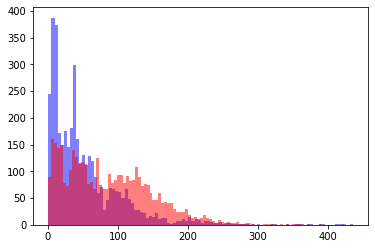

In [42]:
hist_score = NORMAL.astype(np.uint16)
plt.hist(hist_score,color='blue',alpha=0.5,bins=100)
hist_score = ABNORMAL.astype(np.uint16)
plt.hist(hist_score,color='red',alpha=0.5,bins=100)

In [ ]:
# Histogram of Mean Square Error


In [ ]:
# ROC Curve [ AUC : 0.96 ]